# Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

In [ ]:
#Dependencies to load the dataset in tf.data format
!pip install med_dataloader==0.1.12 -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 21.0 MB/s eta 0:00:00


In [ ]:
pip install seaborn

In [ ]:
#Link colab to the directories of a given google drive account
import os
from google.colab import drive
ROOT_PATH = os.path.join(os.sep, 'content' , 'gdrive')
drive.mount(ROOT_PATH)

Mounted at /content/gdrive


In [ ]:
ROOT_PATH

'/content/gdrive'

In [ ]:
#Possible usefull dependencies
import med_dataloader as mdl
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model
import keras

from datetime import datetime
from dateutil.tz import gettz
import SimpleITK as sitk

import scipy
import cv2

import SimpleITK as sitk
import imageio
import re
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
WD_PATH = os.path.join(ROOT_PATH, 'MyDrive', 'PROJECT_NEURO')

DATASET_PATH = os.path.join(WD_PATH, 'Dataset_GS') #Move the folder containig dataset (e.g. Dataset_SP) into WD_PATH

MODELS_PATH = os.path.join(WD_PATH, 'Models') #Folder where best trained models will be saved

if not os.path.exists(MODELS_PATH): #si può togliere
    os.mkdir(MODELS_PATH)


# Data Loader

In [ ]:
NUM_CLASSES=7
seed=42

X_train_denoised=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/Processed_X/X_train_denoised.npy')
y_train=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/y/y_train.npy')
X_val_denoised=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/Processed_X/X_val_denoised.npy')
X_test_denoised=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/Processed_X/X_test_denoised.npy')
y_val=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/y/y_val.npy')
y_test=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/y/y_test.npy')

number_augmented=300 #number of augmented samples to add to train set
if number_augmented>0:
  X_augmented=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/Processed_X/X_train_denoised_augmented.npy')
  y_augmented=np.load('/content/gdrive/MyDrive/PROJECT_NEURO/y/y_train_augmented.npy')
  random_indices = np.random.choice(500, number_augmented, replace=False)
  selected_X_augmented=X_augmented[random_indices]
  selected_y_augmented=y_augmented[random_indices]
  X_train_denoised = np.concatenate((X_train_denoised, selected_X_augmented), axis=0)
  y_train = np.concatenate((y_train, selected_y_augmented), axis=0)
  (X_train_denoised,y_train)=shuffle(X_train_denoised,y_train,random_state=seed)

In [ ]:
print(X_train_denoised.shape)
print(X_val_denoised.shape)
print(X_test_denoised.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(874, 256, 256)
(163, 256, 256)
(83, 256, 256)
(874, 256, 256, 7)
(163, 256, 256, 7)
(83, 256, 256, 7)


# Loss Function

## Cross entropy
 $\, L_{CE} = -\sum_{c=1}^{C} \frac{1}{N} \sum_{i=1}^{N} g_i^c\,log\,p_i^c \quad$ [[1]](https://www.sciencedirect.com/science/article/pii/S1361841521000815)

where:
* $C$ = n°classes
* $N$ = n°pixels of image (256x256)
* $g_i^c$ = value of the $i^{th}$ pixel of the $c^{th}$ class of the ground truth label
* $p_i^c$ = value of the $i^{th}$ pixel of the $c^{th}$ class of the predicted label

In [ ]:
def cross_entropy(num_classes):
    def loss(y_true, y_pred): #called each iteration (step)

        if len(y_pred.shape) == 4: #2D image
            axis = (1,2)
        elif len(y_pred.shape) == 5: #3D volume
            axis == (1,2,3)

        y_true = tf.cast(y_true, dtype = tf.float32)
        y_pred = tf.cast(y_pred, dtype = tf.float32)

        loss_image = 0.0
        loss_ce = 0.0

        for c in range(num_classes):

            loss_image = tf.math.add(-1*(tf.math.reduce_mean(tf.math.multiply(y_true[...,c], tf.math.log(y_pred[...,c] + 1e-9)), axis = axis)), loss_image)

        loss_ce = tf.math.reduce_mean(loss_image)

        return loss_ce

    return loss

#in model.compile can also be set the default tf.keras.losses.CategoricalCrossentropy()

## Weighted cross-entropy
we define a different loss function that weight the loss depending on the label. We made this choice in order to increase the impact of underrepresented classes (es. upper lip)

In [ ]:
class_elements = {}
class_weights = {}
for class_index in range(NUM_CLASSES):
    class_elements[class_index] = 0
    class_weights[class_index] = 0.0

for train_index in range(len(y_train)):
    image = y_train[train_index,:,:,:]
    for class_index in range(NUM_CLASSES):
        class_elements[class_index] += np.sum(image[:,:,class_index] == 1)

for class_index in class_weights.keys():
    class_weights[class_index] = sum(class_elements.values()) / (NUM_CLASSES * class_elements[class_index])


def weighted_cross_entropy(class_weights,NUM_CLASSES=7):
    def loss(y_true, y_pred):
        if len(y_pred.shape) == 4:
            axis = (1, 2)
        elif len(y_pred.shape) == 5:
            axis = (1, 2, 3)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        loss_image = 0.0
        loss_ce = 0.0
        for c in range(NUM_CLASSES):
            loss_image = tf.math.add(-1*(tf.math.reduce_mean(tf.math.multiply(class_weights[c]*y_true[:,:,:,c], tf.math.log(y_pred[:,:,:,c]+1e-9)), axis=axis)), loss_image)
        loss_ce = tf.math.reduce_mean(loss_image)
        return loss_ce
    return loss

# Metric
 We used as metrics:
 - Mean DICE [[3]](https://bmcmedimaging.biomedcentral.com/track/pdf/10.1186/s12880-015-0068-x.pdf)
 - IoU, Intersection over Union [[4]](https://doi.org/10.1007/978-3-319-50835-1_22)
 - Accuracy
 - Precision
 - Recall

## Mean DICE
 $\, DICE = \frac{1}{C}  \sum_{c = 1}^{C} \frac{2 \lvert S_g^c \cap S_p^c \rvert}{\lvert S_g^c \rvert + \lvert S_p^c \rvert} = \frac{2\,\sum_{c=1}^{C}\sum_{i=1}^{N}g_i^c\,p_i^c}{\sum_{c=1}^{C}\sum_{i=1}^{N}g_i^c \,+\, \sum_{c=1}^{C}\sum_{i=1}^{N}p_i^c  } \quad$ [[3]](https://bmcmedimaging.biomedcentral.com/track/pdf/10.1186/s12880-015-0068-x.pdf)

In [ ]:
class Mean_DICE(tf.keras.metrics.Metric):
    def __init__(self,
                 num_classes,
                 name='Mean_DICE',
                 smooth_factor = 1e-9,
                 **kwargs):

        super().__init__(name = name, **kwargs)
        self.num_classes = num_classes
        self.axis = None
        self.smooth_factor = smooth_factor

    def update_state(self, y_true, y_pred, sample_weight=None):

        num_classes = self.num_classes
        y_true = tf.cast(y_true, dtype = tf.float32)
        y_pred = tf.cast(y_pred, dtype = tf.float32)

        dice_classes = 0.0
        dice_image = 0.

        if len(y_pred.shape) == 4:
            self.axis = (1,2)
        elif len(y_pred.shape) == 5:
            self.axis = (1,2,3)

        for c in range(num_classes):

            abs_label = tf.math.reduce_sum(y_true[...,c], axis = self.axis )
            abs_pred = tf.math.reduce_sum(y_pred[...,c], axis = self.axis )
            MD_batch_denom = tf.math.add(tf.math.add(abs_label, abs_pred), self.smooth_factor)
            MD_batch_num = tf.math.add(2*tf.math.reduce_sum(tf.math.multiply(y_true[...,c], y_pred[...,c]), axis = self.axis), self.smooth_factor)
            dice_image = tf.math.divide(MD_batch_num, MD_batch_denom)
            dice_classes = tf.math.add(dice_image, dice_classes)

        self.mean_dice = tf.math.divide(dice_classes, num_classes)
        self.mean_dice = tf.math.reduce_mean(self.mean_dice)

    def result(self):
        return self.mean_dice

    def get_config(self):
        config = super().get_config()
        config.update({'num_classes': self.num_classes})
        return config

    @ classmethod
    def from_config(cls, config):
        return cls(**config)


# Define VizCallback

In [ ]:
# Define a callback class for visualization during training
class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, image, label, folder_path):
        super().__init__()
        self.image = image
        self.label = label
        self.folder_path = folder_path

    def on_epoch_end(self, epoch, logs=None):
        # Predict using the model and visualize ground truth vs predicted mask
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (256, 256, 1))
        print(y_pred.shape)

        y_label = tf.math.argmax(self.label, axis=-1)
        y_label = np.array(y_label)
        y_label = np.reshape(y_label, (256, 256, 1))

        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        axes[0].imshow(np.squeeze(y_label))
        axes[0].set_title("Ground Truth Mask")

        axes[1].imshow(np.squeeze(y_pred))
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()

        extent_ax0 = axes[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        extent_ax1 = axes[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())

        path = os.path.join(self.folder_path, str(epoch))
        plt.savefig(path, bbox_inches='tight')  #fig.savefig(path, bbox_inches=extent_ax1.expanded(1, 0.75))
        plt.show()

# Architecture

In [ ]:
def encoder_block(input_layer, num_filter1a, num_filter1b, num_filter2, num_block, activation='relu', dropout=0.5):
  #out1=residual
  #out2=quello che deve uscire alla fine

  bn1a=tfkl.BatchNormalization(name='bn_block'+str(num_block)+'_section_1a')(input_layer)
  act1a=tfkl.Activation(activation,name='relu_block'+str(num_block)+'_section1a')(bn1a)
  conv1a=tfkl.Conv2D(num_filter1a, kernel_size=3, padding='same', name='conv_block'+str(num_block)+'_section1a')(act1a)

  bn1b=tfkl.BatchNormalization(name='bn_block'+str(num_block)+'_section_1b')(conv1a)
  act1b=tfkl.Activation(activation,name='relu_block'+str(num_block)+'_section1b')(bn1b)
  conv1b=tfkl.Conv2D(num_filter1b, kernel_size=3, padding='same', name='conv_block'+str(num_block)+'_section1b')(act1b)

  conv2=tfkl.Conv2D(num_filter2,kernel_size=3,padding='same', name='conv_block'+str(num_block)+'_section2')(input_layer)
  bn2=tfkl.BatchNormalization(name='bn_block'+str(num_block)+'_section2')(conv2)

  out1 = tfkl.Add(name='add_block'+str(num_block))([conv1b,bn2])

  max_pool=tfkl.MaxPooling2D(pool_size=(2, 2), strides=2, name='maxpool_block'+str(num_block))(out1)

  out2=tfkl.Dropout(rate=dropout,name='drop_block'+str(num_block))(max_pool)

  return (out1,out2)




def decoder_bloc(input_layer,residual_layer,num_filter1,num_filter2a,num_filter2b,num_filter3,num_block,activation='relu',dropout=0.5):

 # print('input_layer.shape=', input_layer.shape)
 # print('residual_layer.shape=', residual_layer.shape)

  conv1=tfkl.Conv2DTranspose(num_filter1,kernel_size=1,strides=2,padding='same',name='conv_block'+str(num_block)+'_section1')(input_layer) #ANCHE SE NON E' CHIARAMENTE INDICATO NEL PAPER, QUI HO MESSO LA CONV INVERSA PER AUMENTARE LA SIZE
  bn1=tfkl.BatchNormalization(name='bn_block'+str(num_block)+'_section1')(conv1)
  #print('dopo_bn1.shape=', bn1.shape)

  add1=tfkl.concatenate([bn1,residual_layer])

  dropout=tfkl.Dropout(rate=dropout,name='drop_block'+str(num_block))(add1)

  bn2a=tfkl.BatchNormalization(name='bn_block'+str(num_block)+'_section2a')(dropout)
  act2a=tfkl.Activation(activation,name='relu_block'+str(num_block)+'_section2a')(bn2a)
  conv2a=tfkl.Conv2D(num_filter2a,kernel_size=3, padding='same',name='conv_block'+str(num_block)+'_section2a')(act2a) #QUI NON SO COSA METTERE DI KERNEL_SIZE E STRIDE

  bn2b=tfkl.BatchNormalization(name='bn_block'+str(num_block)+'_section2b')(conv2a)
  act2b=tfkl.Activation(activation,name='relu_block'+str(num_block)+'_section2b')(bn2b)
  conv2b=tfkl.Conv2D(num_filter2a,kernel_size=3,padding='same',name='conv_block'+str(num_block)+'_section2b')(act2b) #QUI NON SO COSA METTERE DI KERNEL_SIZE E STRIDE

  conv3=tfkl.Conv2D(num_filter3,kernel_size=3,padding='same',name='conv_block'+str(num_block)+'_section3')(dropout) #QUI NON SO COSA METTERE DI KERNEL_SIZE E STRIDE
  bn3=tfkl.BatchNormalization(name='bn_block'+str(num_block)+'_section3')(conv3)
 # print('dopo bn3.shape=', bn3.shape)

  add2=tfkl.Add(name='add_block'+str(num_block)+'_section2')([conv2b,bn3])

  return add2




def IMU_Net(input_shape, num_classes=7, seed=42):

  tf.random.set_seed(seed)


  #input layer
  input_layer = tfkl.Input(shape=input_shape, name='input_layer')


  #1st block and residual
  num_filter=32 #messo 16 a caso, si può modificare

  conv1a=tfkl.Conv2D(num_filter, kernel_size=3, padding='same', name='conv_block1_section1')(input_layer)
  bn1a=tfkl.BatchNormalization(name='bn_block1_section1')(conv1a)
  act1a=tfkl.Activation('relu',name='relu_block1_section1')(bn1a)

  conv1b=tfkl.Conv2D(num_filter, kernel_size=1, padding='same', name='conv_block1_section2')(input_layer)
  bn1b=tfkl.BatchNormalization(name='bn_block1_section2')(conv1b)

  out1 = tfkl.Add(name='add1')([act1a,bn1b]) #qui usciamo con (256x256xnum_filter)


  #2nd block: 1st encoder
  num_filter1a_1=64
  num_filter1b_1=64
  num_filter2_1=64
  num_block=2
  (residual1,encoder1)=encoder_block(out1, num_filter1a_1, num_filter1b_1, num_filter2_1, num_block)
  #residual1 ha shape (256x256x64)
  #encoder1 ha shape (128x128x64)
  print()


  #3rd block: 2nd encoder
  num_filter1a_2=128
  num_filter1b_2=128
  num_filter2_2=128
  num_block=3
  (residual2,encoder2)=encoder_block(encoder1, num_filter1a_2, num_filter1b_2, num_filter2_2, num_block)
  #residual2 ha shape (128x128x128)
  #encoder2 ha shape (64x64x128)


  #4th block: 3rd encoder
  num_filter1a_3=256
  num_filter1b_3=256
  num_filter2_3=256
  num_block=4
  (residual3,encoder3)=encoder_block(encoder2, num_filter1a_2, num_filter1b_2, num_filter2_2,num_block)
  #residual3 ha shape (64x64x256)
  #encoder3 ha shape (32x32x256)


  #5th block: 4th encoder
  num_filter1a_4=512
  num_filter1b_4=512
  num_filter2_4=512
  num_block=5
  (residual4,encoder4)=encoder_block(encoder3, num_filter1a_4, num_filter1b_4, num_filter2_4,num_block)
  #residual4 ha shape (32x32x512)
  #encoder 4 ha shape (16x16x512)


  #6th block: dilated conv1
  num_filter=1024
  conv_dilated1=tfkl.Conv2D(num_filter, kernel_size=3, padding='same', dilation_rate=1, name='conv_dilated1')(encoder4)
  #conv_dilated1 ha shape (16x16x1024)


  #7th block: dilated conv2
  num_filter=1024
  conv_dilated2=tfkl.Conv2D(num_filter, kernel_size=3, padding='same', dilation_rate=2, name='conv_dilated2')(conv_dilated1)
  #conv_dilated2 ha shape (16x16x1024)


  #8th block: dilated conv3
  num_filter=1024
  conv_dilated3=tfkl.Conv2D(num_filter, kernel_size=3, padding='same', dilation_rate=4, name='conv_dilated3')(conv_dilated2)
  #conv_dilated3 ha shape (16x16x1024)


  #9th block: dilated conv4
  num_filter=1024
  conv_dilated4=tfkl.Conv2D(num_filter, kernel_size=3, padding='same', dilation_rate=8, name='conv_dilated4')(conv_dilated3)
  #conv_dilated4 ha shape (16x16x1024)

  print('dilated4.shape=', conv_dilated4.shape)
  #10th block: 1st decoder
  num_filter1_1d=512 # la transpose convolution è realizzata in accordo a Unet con 512 channels, poi aggiunti agli altri 512 provenienti da residual4
  num_filter2a_1d=512
  num_filter2b_1d=512
  num_filter3_1d=512
  num_block=10
  decoder1=decoder_bloc(conv_dilated4,residual4,num_filter1_1d,num_filter2a_1d,num_filter2b_1d,num_filter3_1d,num_block)
  #decoder1 ha shape (32x32x512)

  print('decoder1.shape=', decoder1.shape)
  #11th block: 2nd decoder
  num_filter1_2d=256
  num_filter2a_2d=256
  num_filter2b_2d=256
  num_filter3_2d=256
  num_block=11
  decoder2=decoder_bloc(decoder1,residual3,num_filter1_2d,num_filter2a_2d,num_filter2b_2d,num_filter3_2d,num_block)
  #decoder2 ha shape (64x64x256)


  #12th block: 3rd decoder
  num_filter1_3d=128
  num_filter2a_3d=128
  num_filter2b_3d=128
  num_filter3_3d=128
  num_block=12
  decoder3=decoder_bloc(decoder2,residual2,num_filter1_3d,num_filter2a_3d,num_filter2b_3d,num_filter3_3d,num_block)
  #decoder3 ha shape (128x128x128)


  #13th block: 4th decoder
  num_filter1_4d=64
  num_filter2a_4d=64
  num_filter2b_4d=64
  num_filter3_4d=64
  num_block=13
  decoder4=decoder_bloc(decoder3,residual1,num_filter1_4d,num_filter2a_4d,num_filter2b_4d,num_filter3_4d,num_block)
  #decoder4 ha shape (256x256x64)


  #14th block: output layer
  num_classes=7
  output=tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(decoder4)


  # create model

  model = tf.keras.Model(inputs=input_layer, outputs=output)

  return model

# Model Building & Callbacks

In [ ]:
model = IMU_Net(input_shape=(256,256,1))
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

learning_rate=0.001
model.compile(
    loss = weighted_cross_entropy(class_weights,NUM_CLASSES),
    optimizer =tfk.optimizers.Adam(learning_rate),
    metrics = ["accuracy",tfk.metrics.Precision(),tfk.metrics.Recall(), Mean_DICE(NUM_CLASSES)]
    )

#Create a directory tree to neatly save the models
training_path = os.path.join(WD_PATH, 'Training''Training_' + datetime.now(gettz("Europe/Rome")).strftime("%Y-%m-%d-T%H:%M"))
checkpoint_path = os.path.join(training_path, 'Checkpoints')
best_model_path = os.path.join(training_path, 'Best Model')
predictions_path = os.path.join(training_path, 'Predictions Images')

if not os.path.exists(training_path):
    os.mkdir(training_path)
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)
if not os.path.exists(best_model_path):
    os.mkdir(best_model_path)
if not os.path.exists(predictions_path):
    os.mkdir(predictions_path)

#Callback to keep track of the model with the best validation
patience_es = 10
patience_sch=4
early_stopping=tfk.callbacks.EarlyStopping(monitor='val_Mean_DICE', mode='max', patience=patience_es, restore_best_weights=True)
scheduler=tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=patience_sch, min_lr=1e-5)
viz_callback = VizCallback(np.expand_dims(X_val_denoised[0],axis=0), np.expand_dims(y_val[0],axis=0), predictions_path)


dilated4.shape= (None, 16, 16, 1024)
decoder1.shape= (None, 32, 32, 512)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv_block1_section1 (Conv  (None, 256, 256, 32)         320       ['input_layer[0][0]']         
 2D)                                                                                              
                                                                                                  
 bn_block1_section1 (BatchN  (None, 256, 256, 32)         128       ['conv_block1_section1[0][0]']
 ormalization)                                                                                    
                    

## Visual Keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.4 MB/s eta 0:00:00


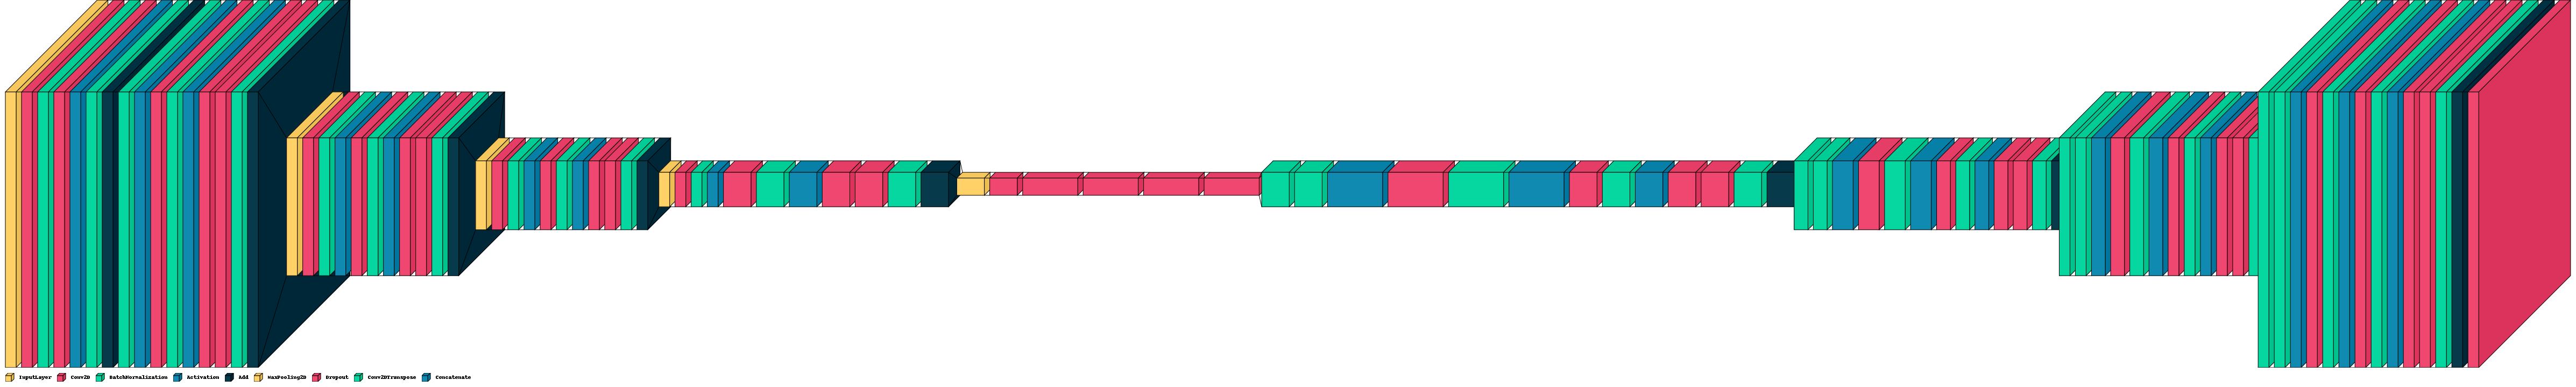

In [ ]:
!pip install visualkeras
import visualkeras
display(visualkeras.layered_view(model, legend=True, scale_xy=2))


#Fit

Epoch 1/50
  6/110 [>.............................] - ETA: 1:41 - loss: 1.7388 - accuracy: 0.6162 - precision: 0.8394 - recall: 0.4855 - Mean_DICE: 0.2718

110/110 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.9085 - precision: 0.9422 - recall: 0.8929 - Mean_DICE: 0.7045(256, 256, 1)


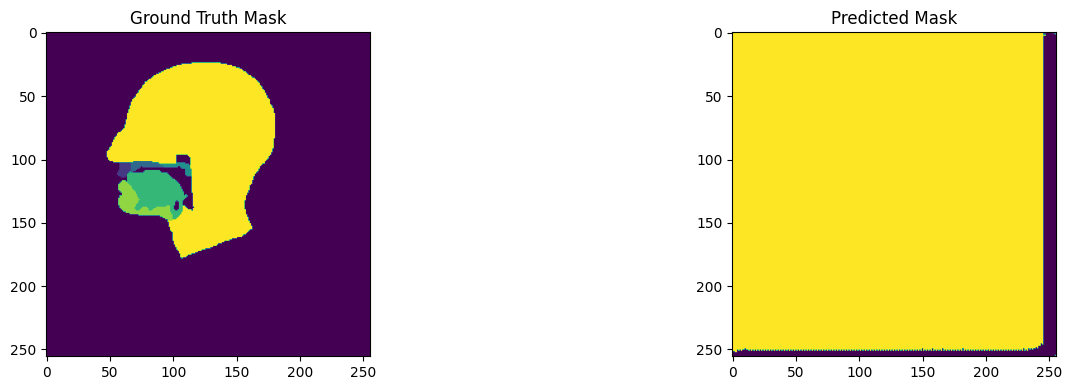

110/110 [==============================] - 196s 1s/step - loss: 0.3661 - accuracy: 0.9085 - precision: 0.9422 - recall: 0.8929 - Mean_DICE: 0.7045 - val_loss: 14.2342 - val_accuracy: 0.2351 - val_precision: 0.2350 - val_recall: 0.2349 - val_Mean_DICE: 0.0659 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9710 - precision: 0.9726 - recall: 0.9699 - Mean_DICE: 0.7708(256, 256, 1)


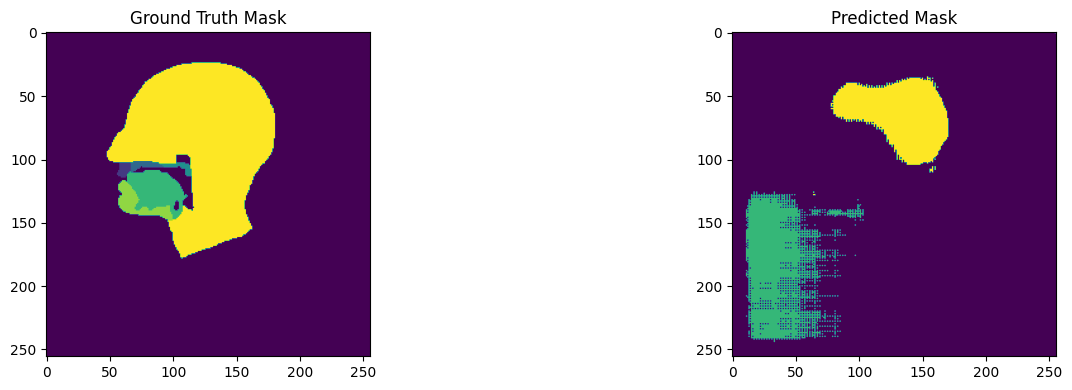

110/110 [==============================] - 118s 1s/step - loss: 0.0889 - accuracy: 0.9710 - precision: 0.9726 - recall: 0.9699 - Mean_DICE: 0.7708 - val_loss: 9.0315 - val_accuracy: 0.7710 - val_precision: 0.7843 - val_recall: 0.7527 - val_Mean_DICE: 0.1926 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9768 - precision: 0.9776 - recall: 0.9761 - Mean_DICE: 0.7954(256, 256, 1)


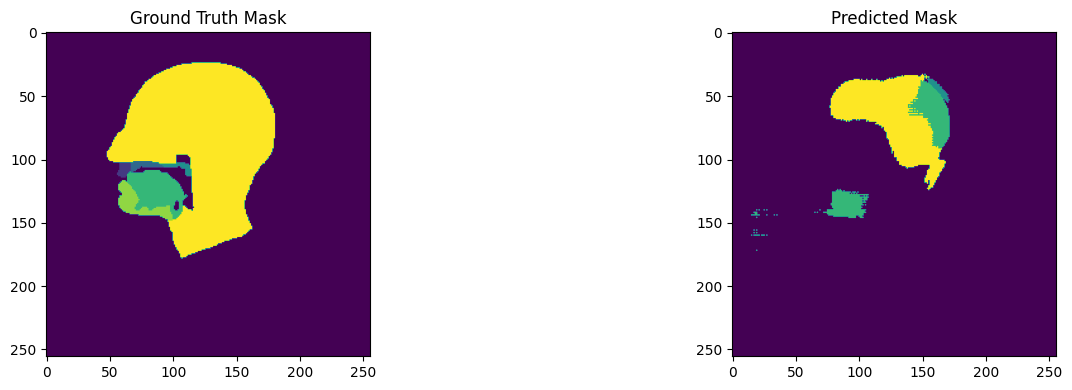

110/110 [==============================] - 123s 1s/step - loss: 0.0763 - accuracy: 0.9768 - precision: 0.9776 - recall: 0.9761 - Mean_DICE: 0.7954 - val_loss: 8.7043 - val_accuracy: 0.8508 - val_precision: 0.8529 - val_recall: 0.8486 - val_Mean_DICE: 0.2135 - lr: 0.0010
Epoch 4/50
110/110 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9789 - precision: 0.9796 - recall: 0.9784 - Mean_DICE: 0.8038(256, 256, 1)


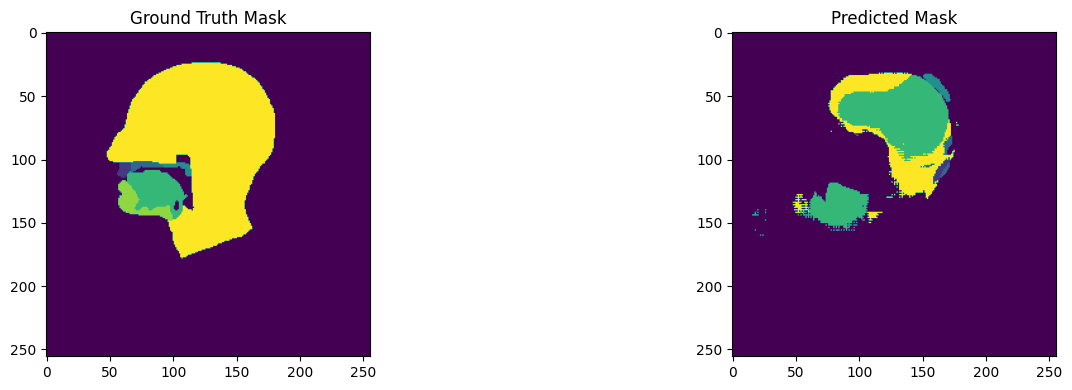

110/110 [==============================] - 123s 1s/step - loss: 0.0685 - accuracy: 0.9789 - precision: 0.9796 - recall: 0.9784 - Mean_DICE: 0.8038 - val_loss: 9.9579 - val_accuracy: 0.8375 - val_precision: 0.8402 - val_recall: 0.8348 - val_Mean_DICE: 0.2073 - lr: 0.0010
Epoch 5/50
110/110 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9795 - precision: 0.9801 - recall: 0.9790 - Mean_DICE: 0.8456(256, 256, 1)


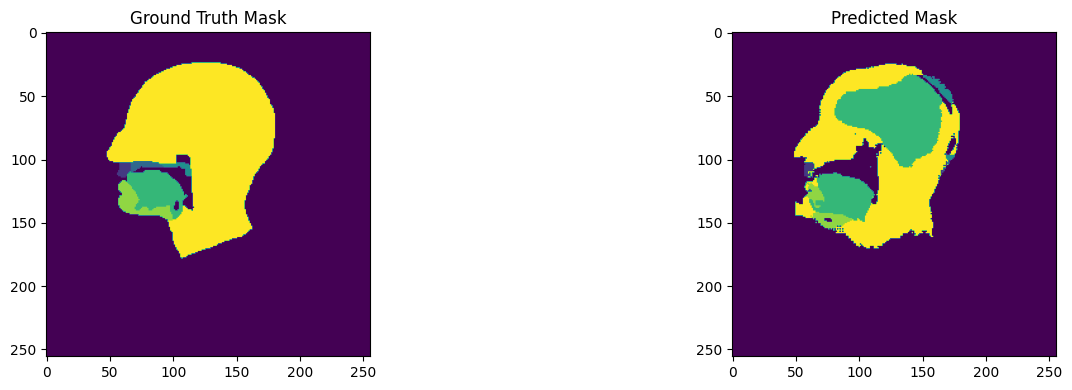

110/110 [==============================] - 123s 1s/step - loss: 0.0658 - accuracy: 0.9795 - precision: 0.9801 - recall: 0.9790 - Mean_DICE: 0.8456 - val_loss: 4.1671 - val_accuracy: 0.8985 - val_precision: 0.9004 - val_recall: 0.8972 - val_Mean_DICE: 0.2969 - lr: 0.0010
Epoch 6/50
110/110 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9803 - precision: 0.9809 - recall: 0.9799 - Mean_DICE: 0.7911(256, 256, 1)


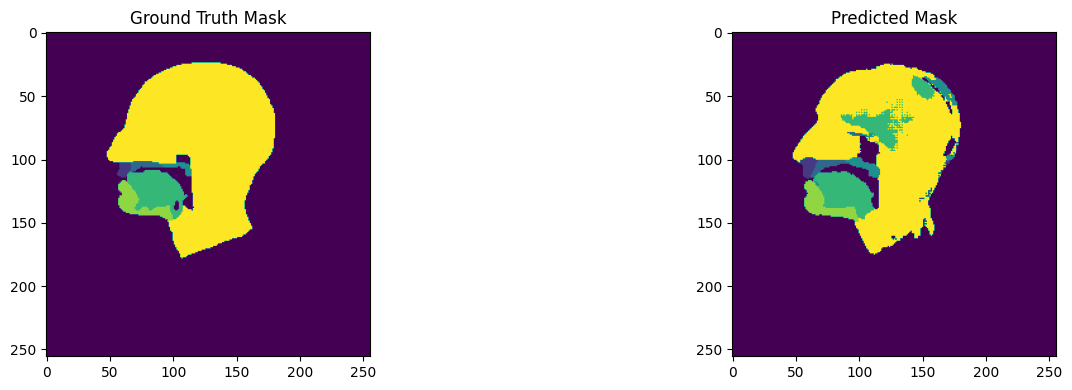

110/110 [==============================] - 119s 1s/step - loss: 0.0641 - accuracy: 0.9803 - precision: 0.9809 - recall: 0.9799 - Mean_DICE: 0.7911 - val_loss: 0.4029 - val_accuracy: 0.9556 - val_precision: 0.9569 - val_recall: 0.9546 - val_Mean_DICE: 0.7105 - lr: 0.0010
Epoch 7/50
110/110 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9805 - precision: 0.9810 - recall: 0.9801 - Mean_DICE: 0.8312(256, 256, 1)


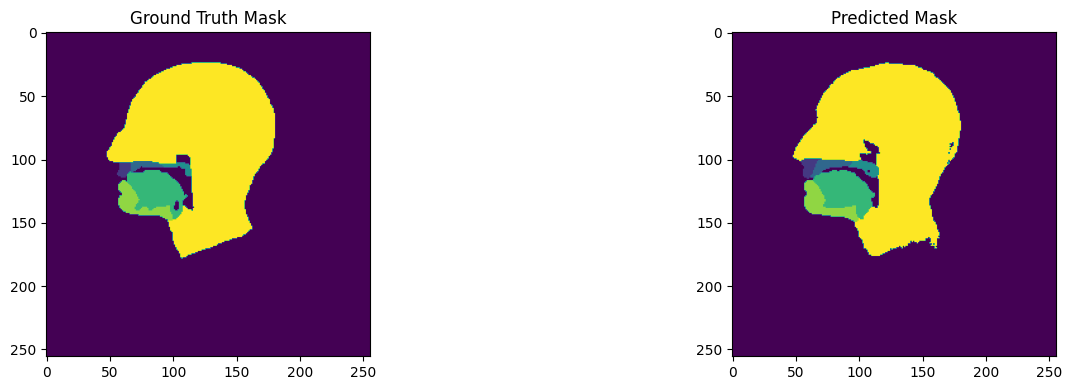

110/110 [==============================] - 123s 1s/step - loss: 0.0627 - accuracy: 0.9805 - precision: 0.9810 - recall: 0.9801 - Mean_DICE: 0.8312 - val_loss: 0.1787 - val_accuracy: 0.9825 - val_precision: 0.9829 - val_recall: 0.9822 - val_Mean_DICE: 0.8545 - lr: 0.0010
Epoch 8/50
110/110 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9806 - precision: 0.9811 - recall: 0.9802 - Mean_DICE: 0.8148(256, 256, 1)


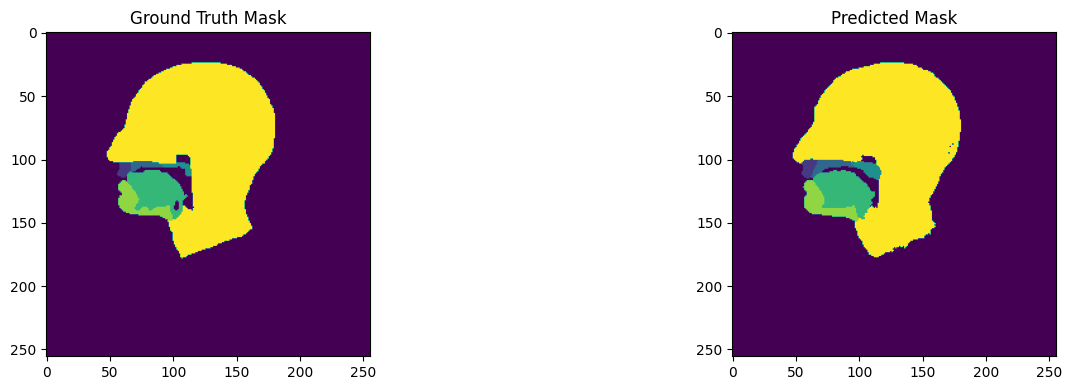

110/110 [==============================] - 123s 1s/step - loss: 0.0626 - accuracy: 0.9806 - precision: 0.9811 - recall: 0.9802 - Mean_DICE: 0.8148 - val_loss: 0.0830 - val_accuracy: 0.9866 - val_precision: 0.9868 - val_recall: 0.9864 - val_Mean_DICE: 0.8641 - lr: 0.0010
Epoch 9/50
110/110 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9815 - precision: 0.9819 - recall: 0.9812 - Mean_DICE: 0.8324(256, 256, 1)


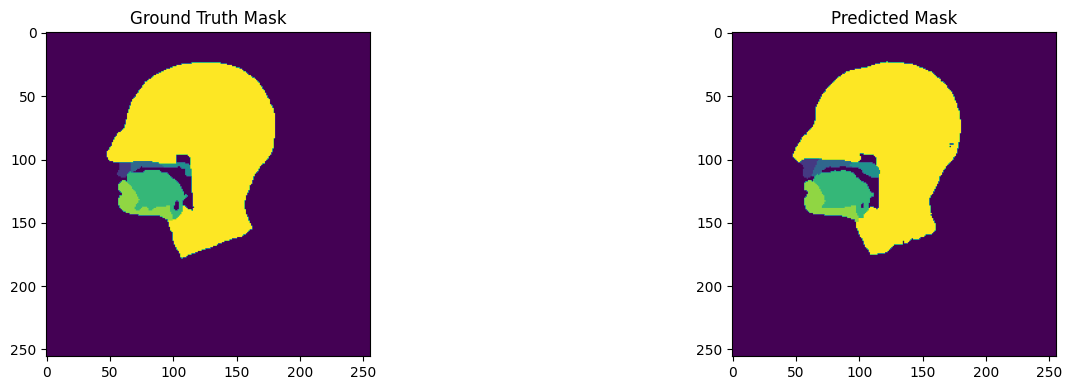

110/110 [==============================] - 118s 1s/step - loss: 0.0591 - accuracy: 0.9815 - precision: 0.9819 - recall: 0.9812 - Mean_DICE: 0.8324 - val_loss: 0.1158 - val_accuracy: 0.9861 - val_precision: 0.9864 - val_recall: 0.9858 - val_Mean_DICE: 0.8551 - lr: 0.0010
Epoch 10/50
110/110 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9814 - precision: 0.9819 - recall: 0.9811 - Mean_DICE: 0.8385(256, 256, 1)


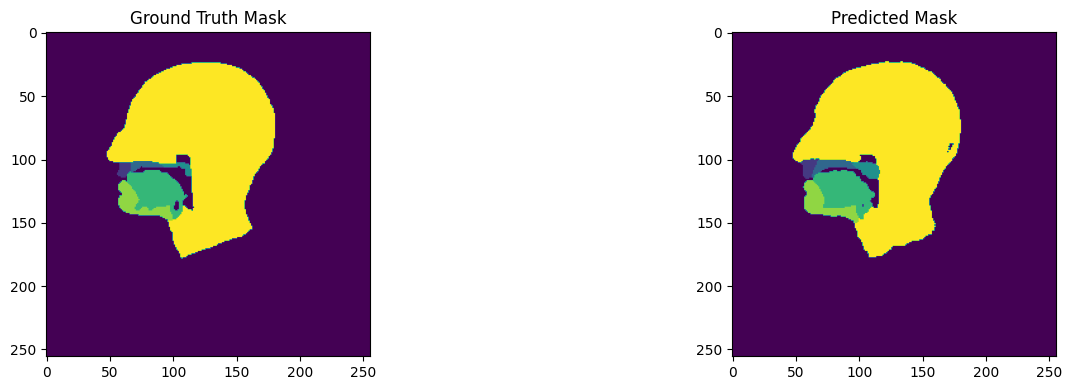

110/110 [==============================] - 123s 1s/step - loss: 0.0579 - accuracy: 0.9814 - precision: 0.9819 - recall: 0.9811 - Mean_DICE: 0.8385 - val_loss: 0.0788 - val_accuracy: 0.9866 - val_precision: 0.9868 - val_recall: 0.9864 - val_Mean_DICE: 0.8516 - lr: 0.0010
Epoch 11/50
110/110 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9819 - precision: 0.9823 - recall: 0.9816 - Mean_DICE: 0.8296(256, 256, 1)


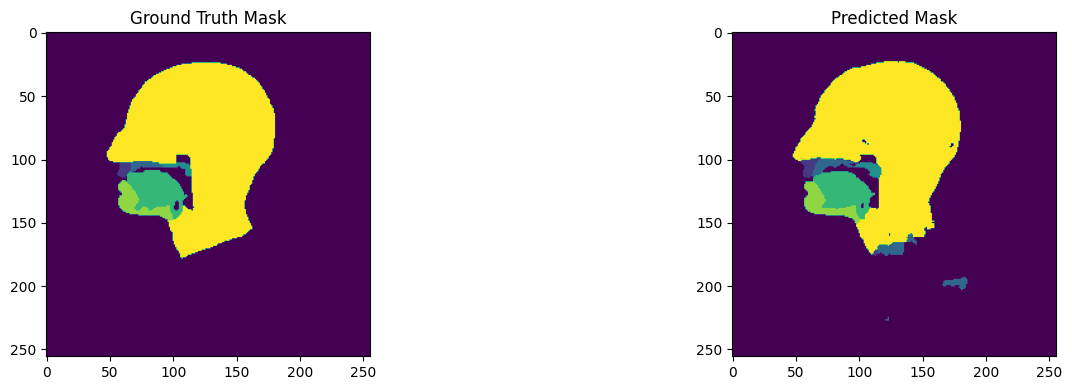

110/110 [==============================] - 123s 1s/step - loss: 0.0574 - accuracy: 0.9819 - precision: 0.9823 - recall: 0.9816 - Mean_DICE: 0.8296 - val_loss: 0.1448 - val_accuracy: 0.9810 - val_precision: 0.9820 - val_recall: 0.9804 - val_Mean_DICE: 0.7731 - lr: 0.0010
Epoch 12/50
110/110 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9822 - precision: 0.9826 - recall: 0.9819 - Mean_DICE: 0.8313(256, 256, 1)


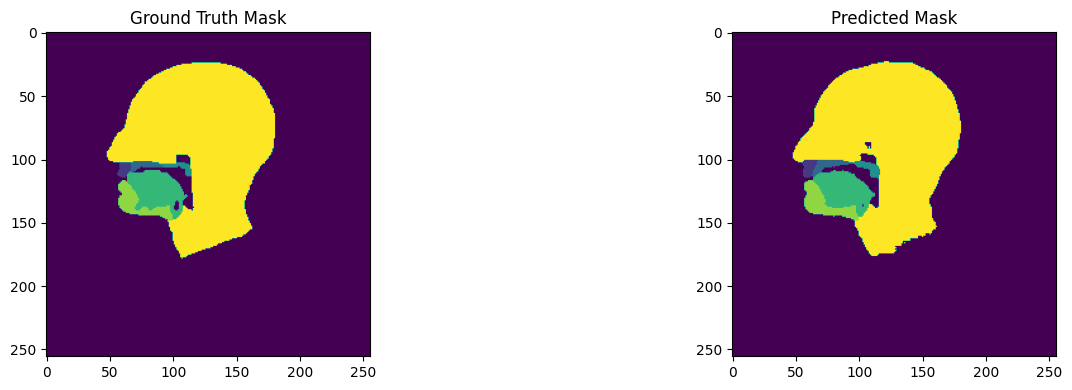

110/110 [==============================] - 123s 1s/step - loss: 0.0574 - accuracy: 0.9822 - precision: 0.9826 - recall: 0.9819 - Mean_DICE: 0.8313 - val_loss: 0.1358 - val_accuracy: 0.9869 - val_precision: 0.9871 - val_recall: 0.9868 - val_Mean_DICE: 0.8713 - lr: 0.0010
Epoch 13/50
110/110 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9824 - precision: 0.9827 - recall: 0.9821 - Mean_DICE: 0.8432(256, 256, 1)


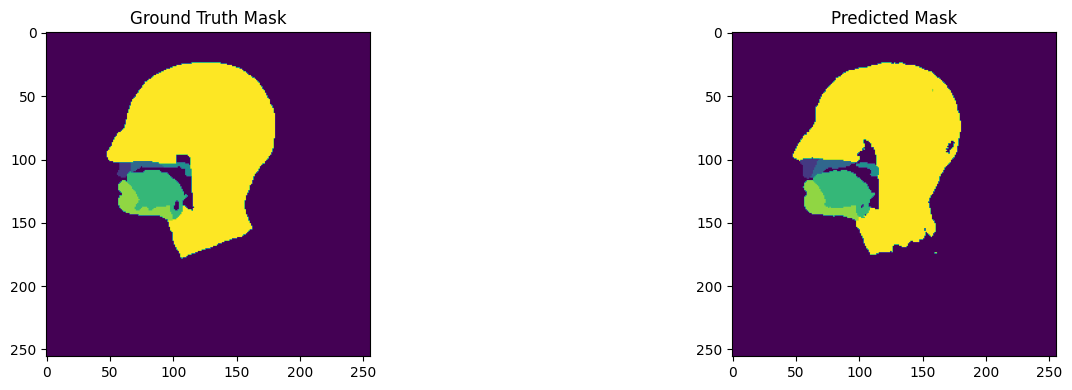

110/110 [==============================] - 118s 1s/step - loss: 0.0552 - accuracy: 0.9824 - precision: 0.9827 - recall: 0.9821 - Mean_DICE: 0.8432 - val_loss: 0.1708 - val_accuracy: 0.9823 - val_precision: 0.9827 - val_recall: 0.9820 - val_Mean_DICE: 0.8523 - lr: 0.0010
Epoch 14/50
110/110 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9823 - precision: 0.9827 - recall: 0.9821 - Mean_DICE: 0.8453(256, 256, 1)


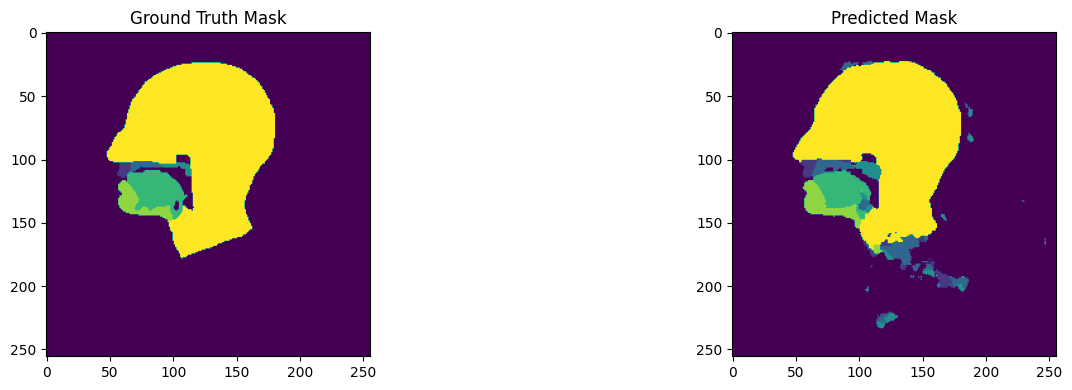

110/110 [==============================] - 118s 1s/step - loss: 0.0549 - accuracy: 0.9823 - precision: 0.9827 - recall: 0.9821 - Mean_DICE: 0.8453 - val_loss: 0.2034 - val_accuracy: 0.9651 - val_precision: 0.9685 - val_recall: 0.9633 - val_Mean_DICE: 0.6299 - lr: 0.0010
Epoch 15/50
110/110 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9831 - precision: 0.9834 - recall: 0.9828 - Mean_DICE: 0.8590(256, 256, 1)


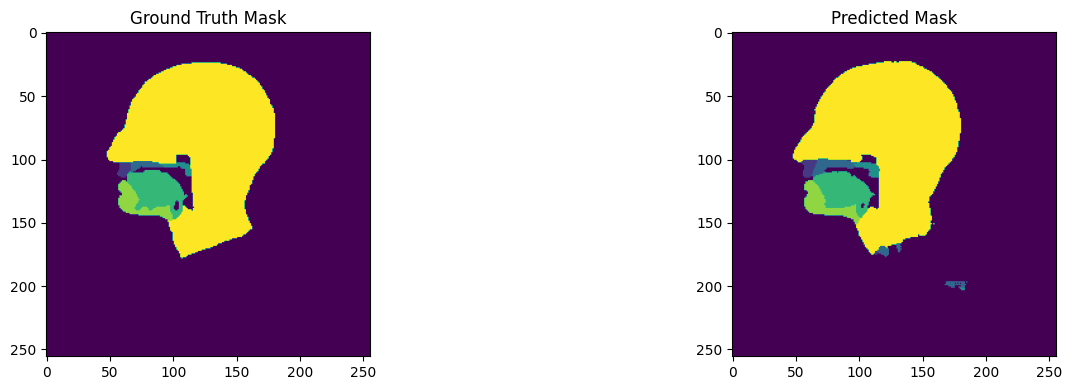

110/110 [==============================] - 123s 1s/step - loss: 0.0523 - accuracy: 0.9831 - precision: 0.9834 - recall: 0.9828 - Mean_DICE: 0.8590 - val_loss: 0.1281 - val_accuracy: 0.9851 - val_precision: 0.9855 - val_recall: 0.9847 - val_Mean_DICE: 0.8336 - lr: 5.0000e-04
Epoch 16/50
110/110 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9830 - precision: 0.9833 - recall: 0.9828 - Mean_DICE: 0.8542(256, 256, 1)


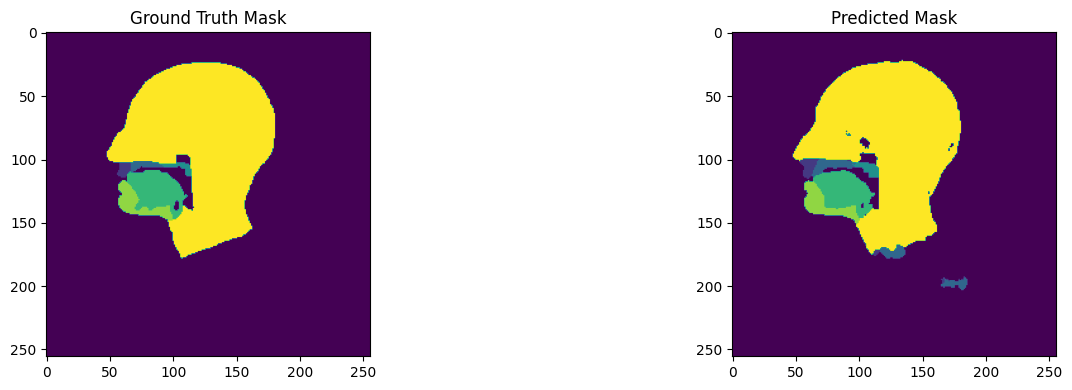

110/110 [==============================] - 123s 1s/step - loss: 0.0508 - accuracy: 0.9830 - precision: 0.9833 - recall: 0.9828 - Mean_DICE: 0.8542 - val_loss: 0.1402 - val_accuracy: 0.9812 - val_precision: 0.9820 - val_recall: 0.9808 - val_Mean_DICE: 0.7987 - lr: 5.0000e-04
Epoch 17/50
110/110 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9832 - precision: 0.9835 - recall: 0.9830 - Mean_DICE: 0.8754(256, 256, 1)


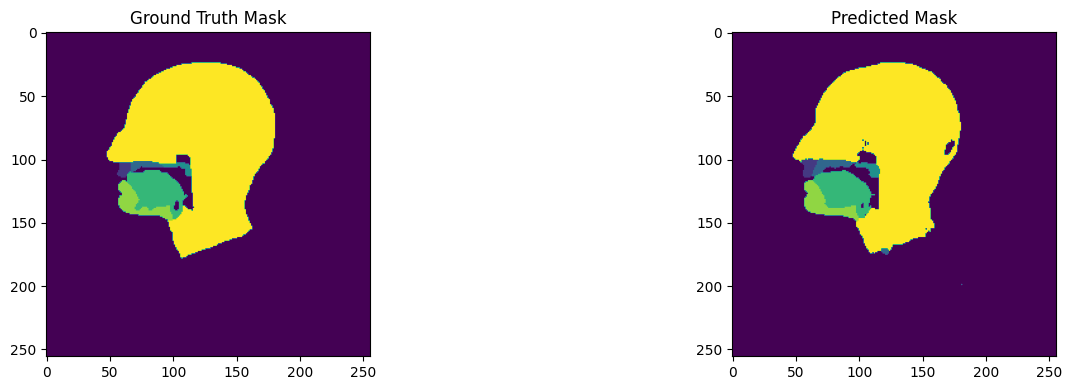

110/110 [==============================] - 118s 1s/step - loss: 0.0505 - accuracy: 0.9832 - precision: 0.9835 - recall: 0.9830 - Mean_DICE: 0.8754 - val_loss: 0.1779 - val_accuracy: 0.9828 - val_precision: 0.9831 - val_recall: 0.9826 - val_Mean_DICE: 0.8594 - lr: 5.0000e-04
Epoch 18/50
110/110 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9835 - precision: 0.9837 - recall: 0.9833 - Mean_DICE: 0.8270(256, 256, 1)


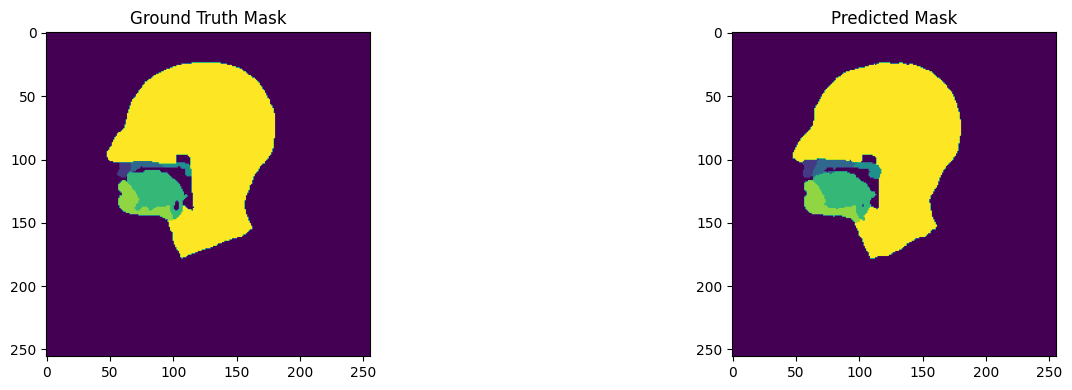

110/110 [==============================] - 118s 1s/step - loss: 0.0505 - accuracy: 0.9835 - precision: 0.9837 - recall: 0.9833 - Mean_DICE: 0.8270 - val_loss: 0.0962 - val_accuracy: 0.9870 - val_precision: 0.9871 - val_recall: 0.9869 - val_Mean_DICE: 0.8736 - lr: 5.0000e-04
Epoch 19/50
110/110 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9838 - precision: 0.9841 - recall: 0.9836 - Mean_DICE: 0.8376(256, 256, 1)


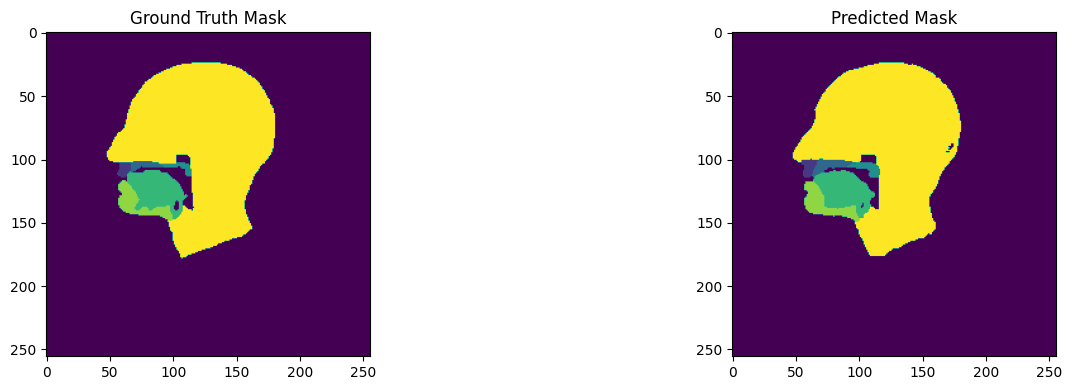

110/110 [==============================] - 123s 1s/step - loss: 0.0478 - accuracy: 0.9838 - precision: 0.9841 - recall: 0.9836 - Mean_DICE: 0.8376 - val_loss: 0.0993 - val_accuracy: 0.9871 - val_precision: 0.9872 - val_recall: 0.9870 - val_Mean_DICE: 0.8774 - lr: 2.5000e-04
Epoch 20/50
110/110 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9840 - precision: 0.9843 - recall: 0.9838 - Mean_DICE: 0.8392(256, 256, 1)


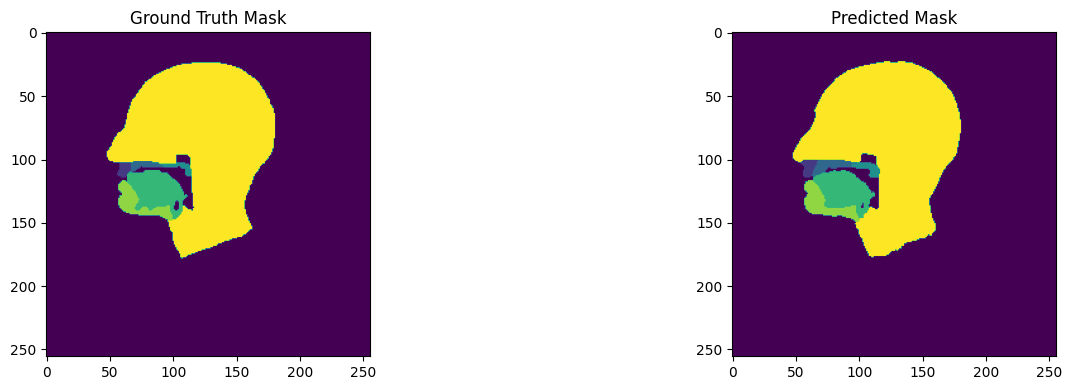

110/110 [==============================] - 124s 1s/step - loss: 0.0476 - accuracy: 0.9840 - precision: 0.9843 - recall: 0.9838 - Mean_DICE: 0.8392 - val_loss: 0.0993 - val_accuracy: 0.9879 - val_precision: 0.9880 - val_recall: 0.9878 - val_Mean_DICE: 0.8810 - lr: 2.5000e-04
Epoch 21/50
110/110 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9838 - precision: 0.9841 - recall: 0.9837 - Mean_DICE: 0.8500(256, 256, 1)


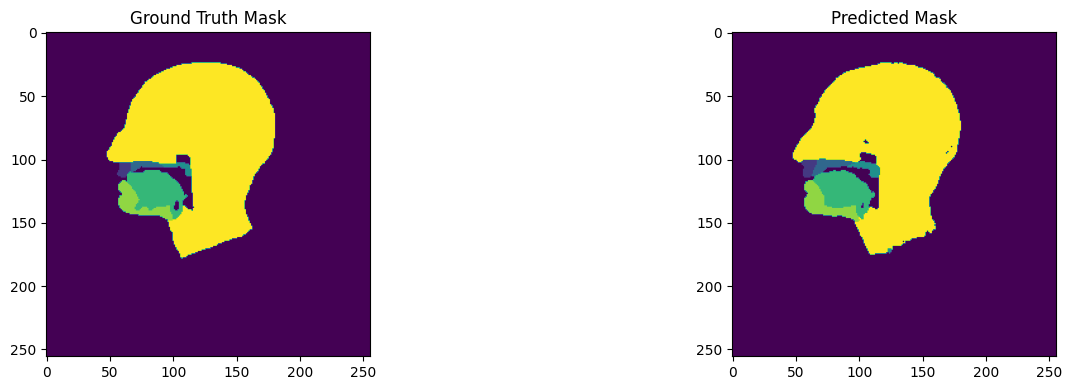

110/110 [==============================] - 123s 1s/step - loss: 0.0473 - accuracy: 0.9838 - precision: 0.9841 - recall: 0.9837 - Mean_DICE: 0.8500 - val_loss: 0.1193 - val_accuracy: 0.9855 - val_precision: 0.9856 - val_recall: 0.9853 - val_Mean_DICE: 0.8787 - lr: 2.5000e-04
Epoch 22/50
110/110 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9838 - precision: 0.9840 - recall: 0.9836 - Mean_DICE: 0.8487(256, 256, 1)


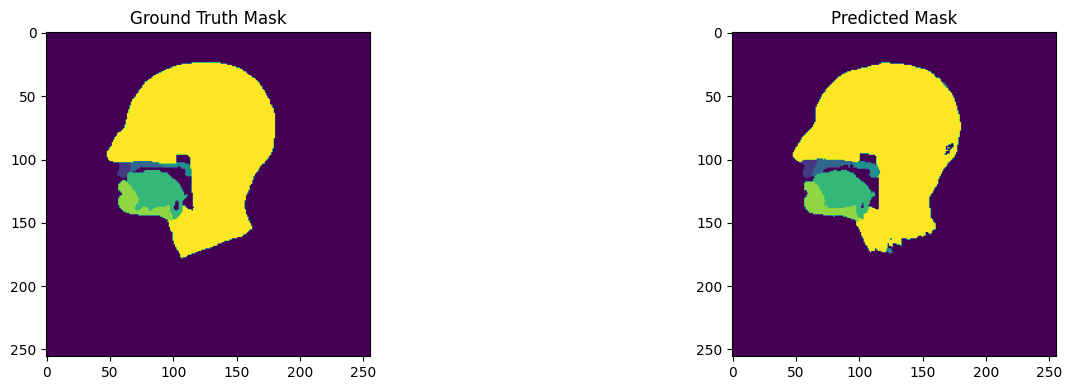

110/110 [==============================] - 119s 1s/step - loss: 0.0472 - accuracy: 0.9838 - precision: 0.9840 - recall: 0.9836 - Mean_DICE: 0.8487 - val_loss: 0.1379 - val_accuracy: 0.9845 - val_precision: 0.9846 - val_recall: 0.9843 - val_Mean_DICE: 0.8832 - lr: 2.5000e-04
Epoch 23/50
110/110 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9842 - precision: 0.9844 - recall: 0.9840 - Mean_DICE: 0.8239(256, 256, 1)


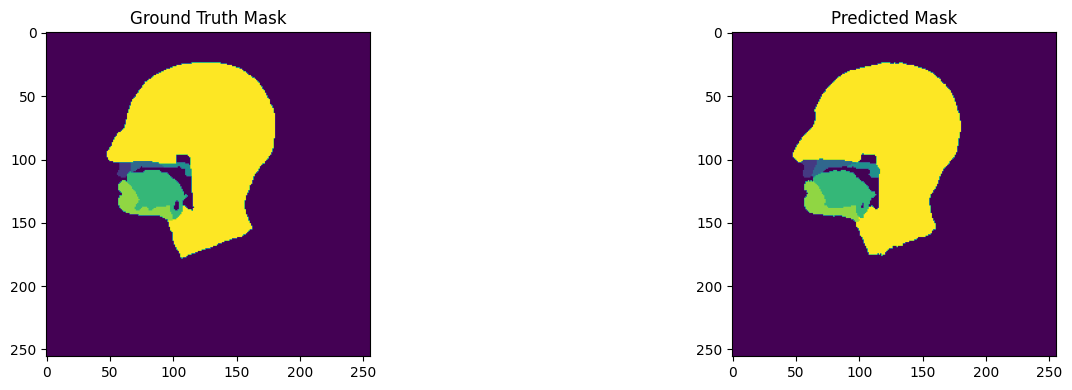

110/110 [==============================] - 123s 1s/step - loss: 0.0453 - accuracy: 0.9842 - precision: 0.9844 - recall: 0.9840 - Mean_DICE: 0.8239 - val_loss: 0.1160 - val_accuracy: 0.9871 - val_precision: 0.9873 - val_recall: 0.9871 - val_Mean_DICE: 0.8875 - lr: 1.2500e-04
Epoch 24/50
110/110 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9843 - precision: 0.9845 - recall: 0.9841 - Mean_DICE: 0.8437(256, 256, 1)


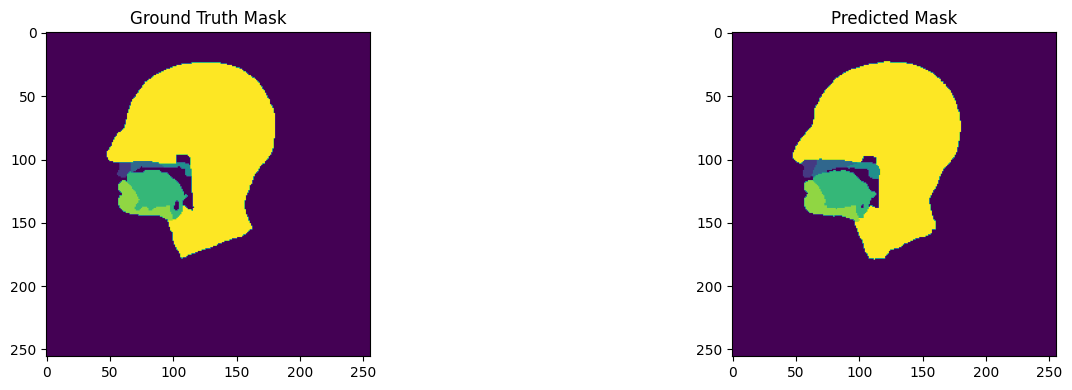

110/110 [==============================] - 123s 1s/step - loss: 0.0449 - accuracy: 0.9843 - precision: 0.9845 - recall: 0.9841 - Mean_DICE: 0.8437 - val_loss: 0.0925 - val_accuracy: 0.9885 - val_precision: 0.9887 - val_recall: 0.9885 - val_Mean_DICE: 0.8833 - lr: 1.2500e-04
Epoch 25/50
110/110 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9842 - precision: 0.9844 - recall: 0.9840 - Mean_DICE: 0.8083(256, 256, 1)


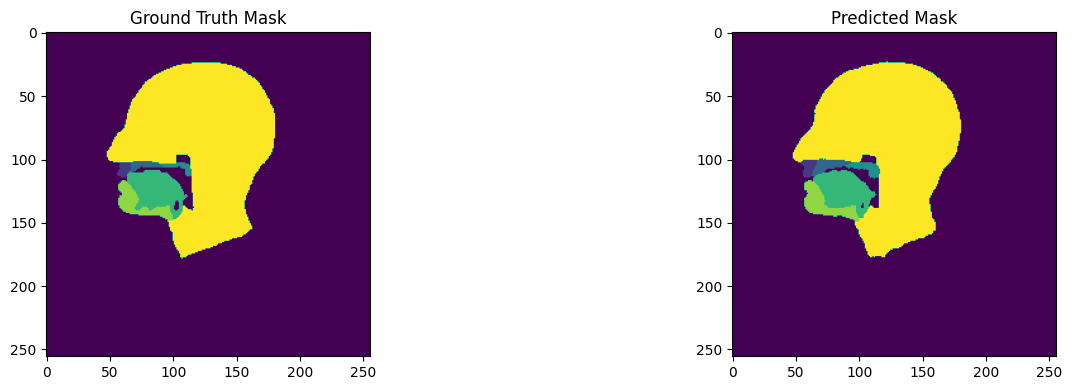

110/110 [==============================] - 123s 1s/step - loss: 0.0449 - accuracy: 0.9842 - precision: 0.9844 - recall: 0.9840 - Mean_DICE: 0.8083 - val_loss: 0.1015 - val_accuracy: 0.9881 - val_precision: 0.9882 - val_recall: 0.9881 - val_Mean_DICE: 0.8855 - lr: 1.2500e-04
Epoch 26/50
110/110 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9842 - precision: 0.9844 - recall: 0.9841 - Mean_DICE: 0.8377(256, 256, 1)


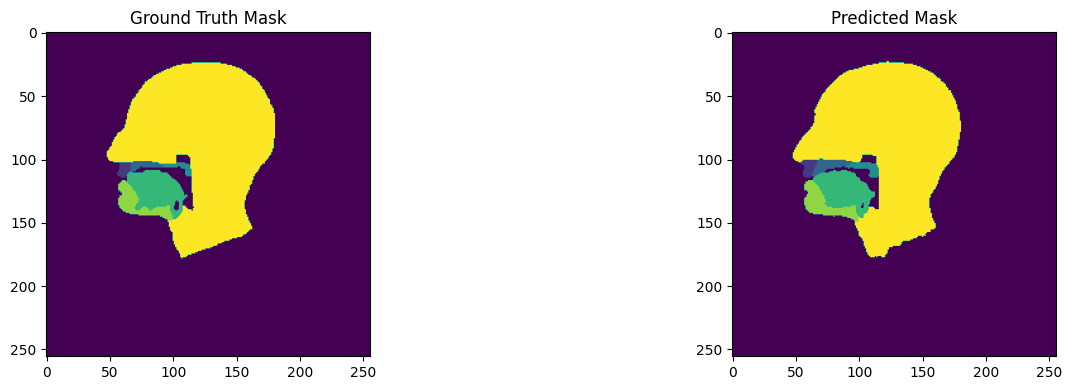

110/110 [==============================] - 123s 1s/step - loss: 0.0443 - accuracy: 0.9842 - precision: 0.9844 - recall: 0.9841 - Mean_DICE: 0.8377 - val_loss: 0.1094 - val_accuracy: 0.9876 - val_precision: 0.9877 - val_recall: 0.9875 - val_Mean_DICE: 0.8881 - lr: 1.2500e-04
Epoch 27/50
110/110 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9845 - precision: 0.9847 - recall: 0.9844 - Mean_DICE: 0.8152(256, 256, 1)


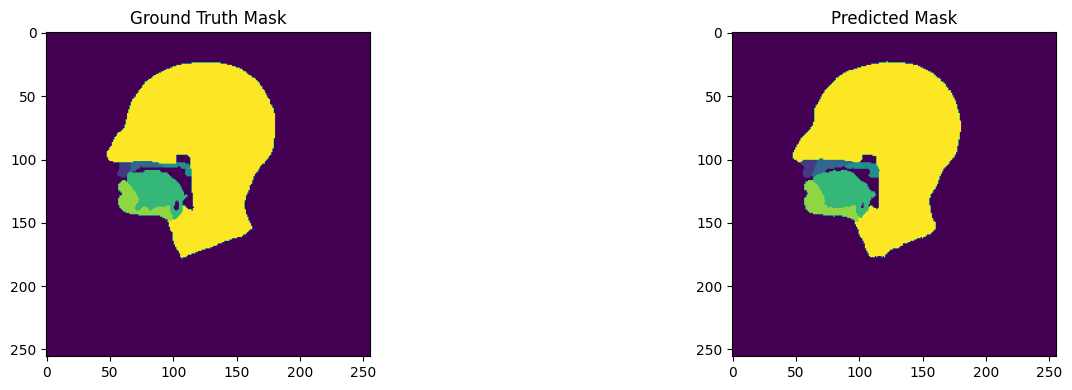

110/110 [==============================] - 123s 1s/step - loss: 0.0434 - accuracy: 0.9845 - precision: 0.9847 - recall: 0.9844 - Mean_DICE: 0.8152 - val_loss: 0.1056 - val_accuracy: 0.9880 - val_precision: 0.9881 - val_recall: 0.9880 - val_Mean_DICE: 0.8859 - lr: 6.2500e-05
Epoch 28/50
110/110 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9846 - precision: 0.9848 - recall: 0.9844 - Mean_DICE: 0.8629(256, 256, 1)


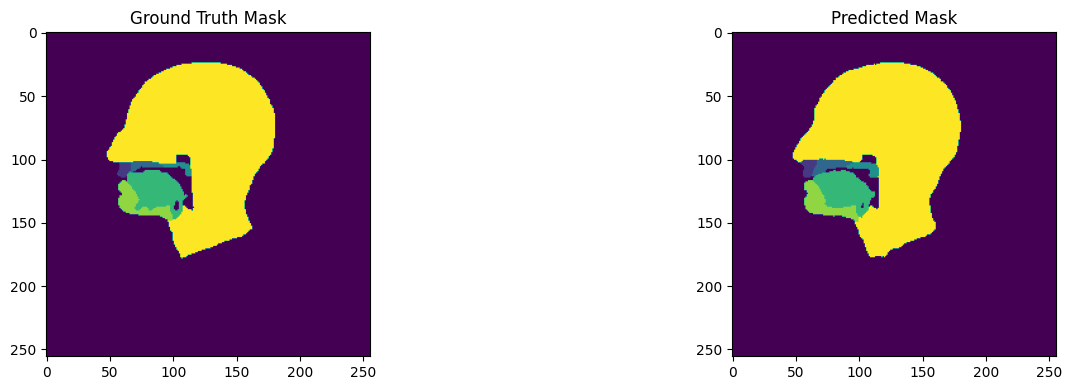

110/110 [==============================] - 123s 1s/step - loss: 0.0433 - accuracy: 0.9846 - precision: 0.9848 - recall: 0.9844 - Mean_DICE: 0.8629 - val_loss: 0.1101 - val_accuracy: 0.9879 - val_precision: 0.9880 - val_recall: 0.9878 - val_Mean_DICE: 0.8871 - lr: 6.2500e-05
Epoch 29/50
110/110 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9846 - precision: 0.9848 - recall: 0.9844 - Mean_DICE: 0.8749(256, 256, 1)


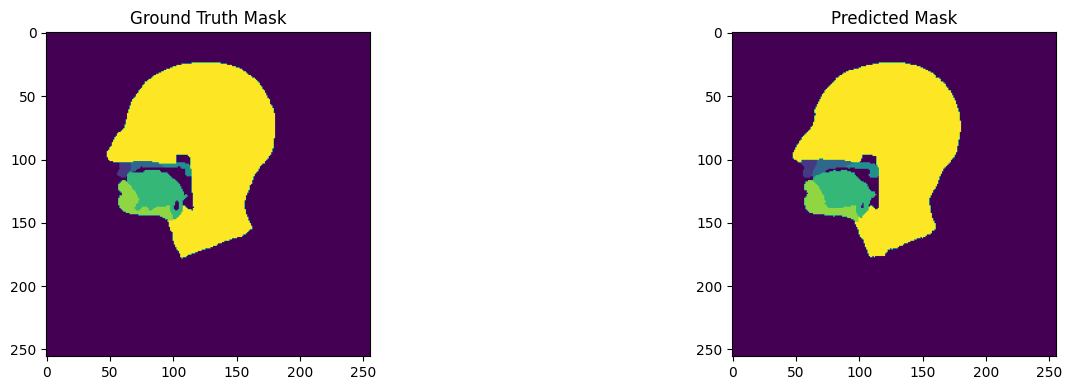

110/110 [==============================] - 123s 1s/step - loss: 0.0430 - accuracy: 0.9846 - precision: 0.9848 - recall: 0.9844 - Mean_DICE: 0.8749 - val_loss: 0.1090 - val_accuracy: 0.9880 - val_precision: 0.9881 - val_recall: 0.9879 - val_Mean_DICE: 0.8892 - lr: 6.2500e-05
Epoch 30/50
110/110 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9845 - precision: 0.9847 - recall: 0.9843 - Mean_DICE: 0.8210(256, 256, 1)


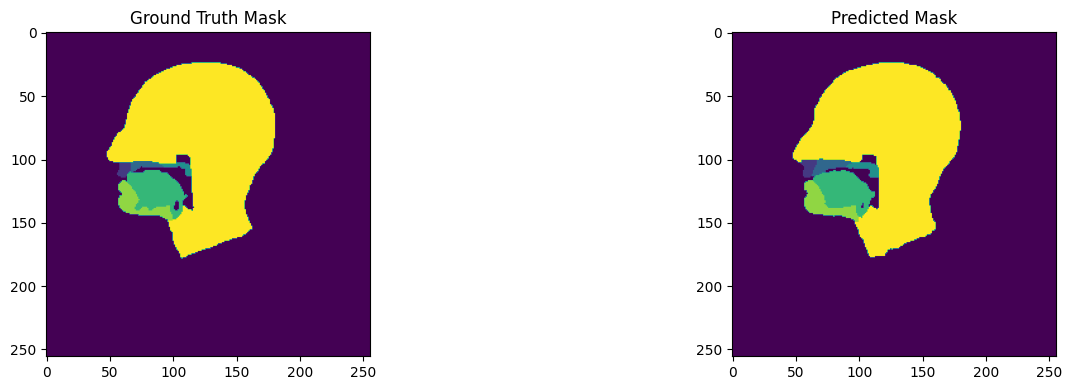

110/110 [==============================] - 118s 1s/step - loss: 0.0430 - accuracy: 0.9845 - precision: 0.9847 - recall: 0.9843 - Mean_DICE: 0.8210 - val_loss: 0.1114 - val_accuracy: 0.9878 - val_precision: 0.9879 - val_recall: 0.9877 - val_Mean_DICE: 0.8855 - lr: 6.2500e-05
Epoch 31/50
110/110 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9847 - precision: 0.9848 - recall: 0.9845 - Mean_DICE: 0.8765(256, 256, 1)


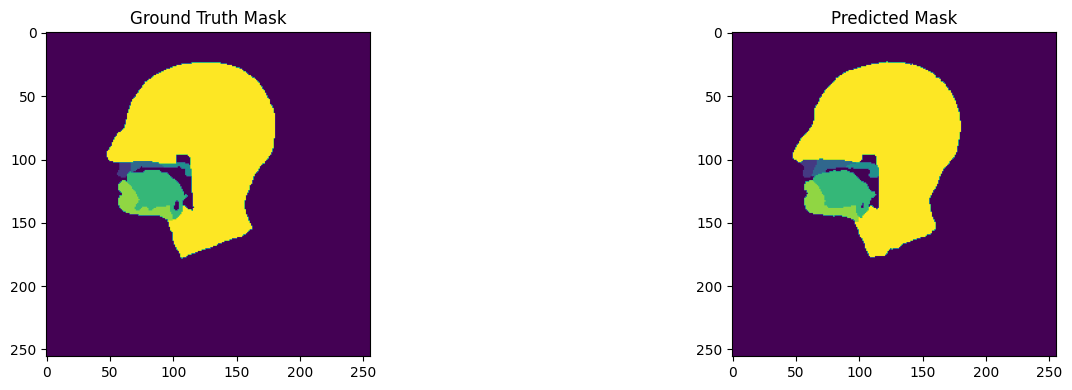

110/110 [==============================] - 123s 1s/step - loss: 0.0424 - accuracy: 0.9847 - precision: 0.9848 - recall: 0.9845 - Mean_DICE: 0.8765 - val_loss: 0.1152 - val_accuracy: 0.9879 - val_precision: 0.9880 - val_recall: 0.9879 - val_Mean_DICE: 0.8859 - lr: 3.1250e-05
Epoch 32/50
110/110 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9847 - precision: 0.9849 - recall: 0.9846 - Mean_DICE: 0.8693(256, 256, 1)


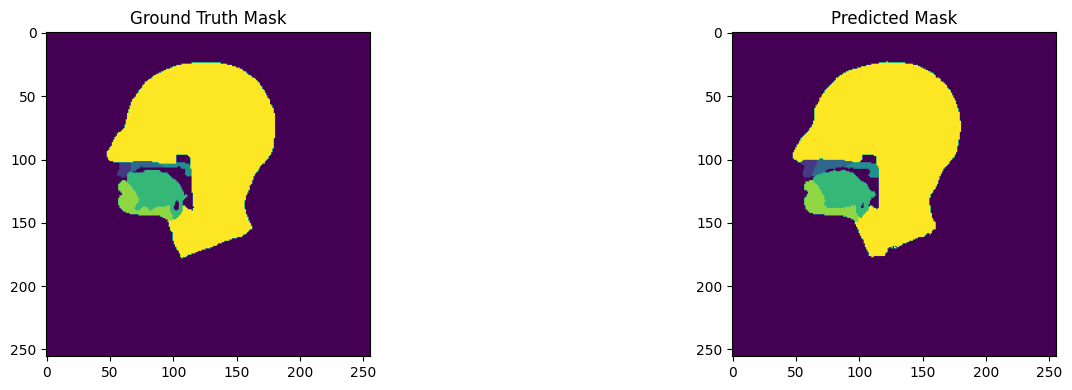

110/110 [==============================] - 123s 1s/step - loss: 0.0422 - accuracy: 0.9847 - precision: 0.9849 - recall: 0.9846 - Mean_DICE: 0.8693 - val_loss: 0.1160 - val_accuracy: 0.9880 - val_precision: 0.9881 - val_recall: 0.9879 - val_Mean_DICE: 0.8884 - lr: 3.1250e-05
Epoch 33/50
110/110 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9847 - precision: 0.9849 - recall: 0.9846 - Mean_DICE: 0.8659(256, 256, 1)


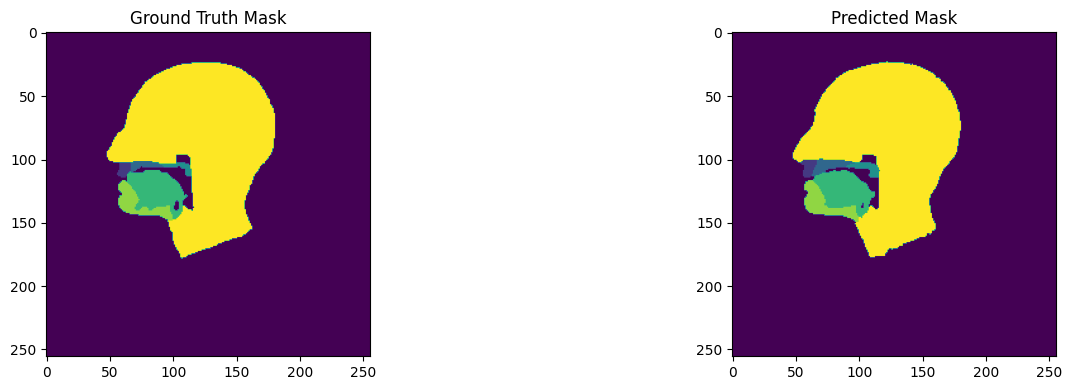

110/110 [==============================] - 119s 1s/step - loss: 0.0420 - accuracy: 0.9847 - precision: 0.9849 - recall: 0.9846 - Mean_DICE: 0.8659 - val_loss: 0.1182 - val_accuracy: 0.9877 - val_precision: 0.9878 - val_recall: 0.9877 - val_Mean_DICE: 0.8881 - lr: 3.1250e-05
Epoch 34/50
110/110 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9847 - precision: 0.9849 - recall: 0.9846 - Mean_DICE: 0.8466(256, 256, 1)


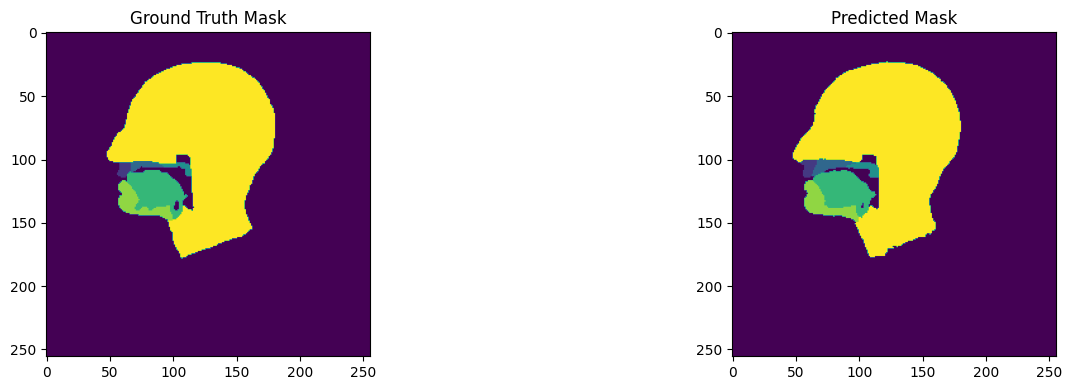

110/110 [==============================] - 118s 1s/step - loss: 0.0422 - accuracy: 0.9847 - precision: 0.9849 - recall: 0.9846 - Mean_DICE: 0.8466 - val_loss: 0.1187 - val_accuracy: 0.9879 - val_precision: 0.9880 - val_recall: 0.9879 - val_Mean_DICE: 0.8885 - lr: 3.1250e-05
Epoch 35/50
110/110 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9849 - precision: 0.9851 - recall: 0.9847 - Mean_DICE: 0.8306(256, 256, 1)


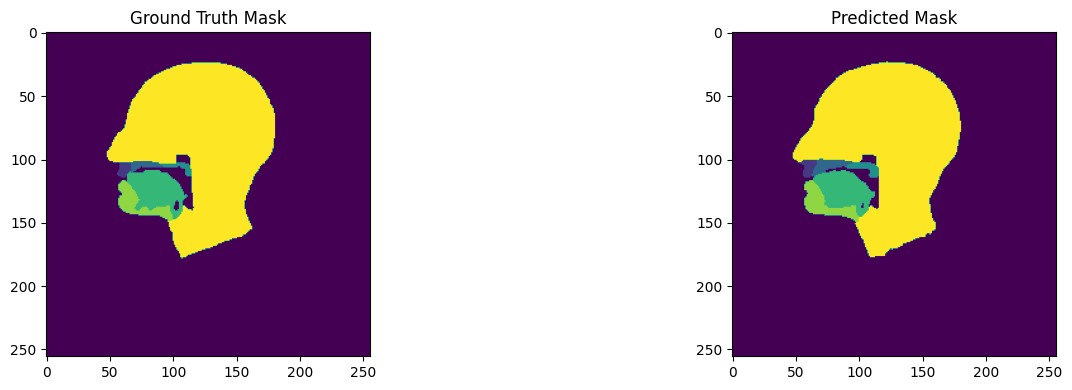

110/110 [==============================] - 123s 1s/step - loss: 0.0418 - accuracy: 0.9849 - precision: 0.9851 - recall: 0.9847 - Mean_DICE: 0.8306 - val_loss: 0.1169 - val_accuracy: 0.9880 - val_precision: 0.9881 - val_recall: 0.9879 - val_Mean_DICE: 0.8875 - lr: 1.5625e-05
Epoch 36/50
110/110 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9847 - precision: 0.9849 - recall: 0.9846 - Mean_DICE: 0.8689(256, 256, 1)


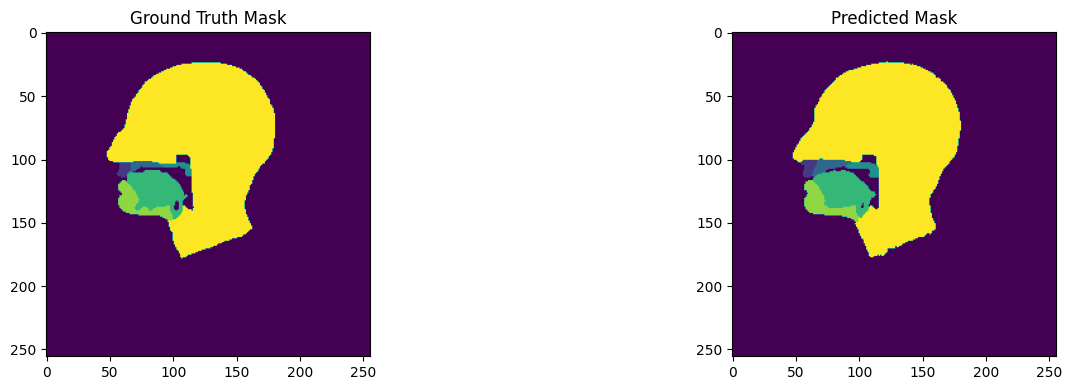

110/110 [==============================] - 123s 1s/step - loss: 0.0420 - accuracy: 0.9847 - precision: 0.9849 - recall: 0.9846 - Mean_DICE: 0.8689 - val_loss: 0.1153 - val_accuracy: 0.9877 - val_precision: 0.9878 - val_recall: 0.9877 - val_Mean_DICE: 0.8869 - lr: 1.5625e-05
Epoch 37/50
110/110 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9849 - precision: 0.9851 - recall: 0.9848 - Mean_DICE: 0.8587(256, 256, 1)


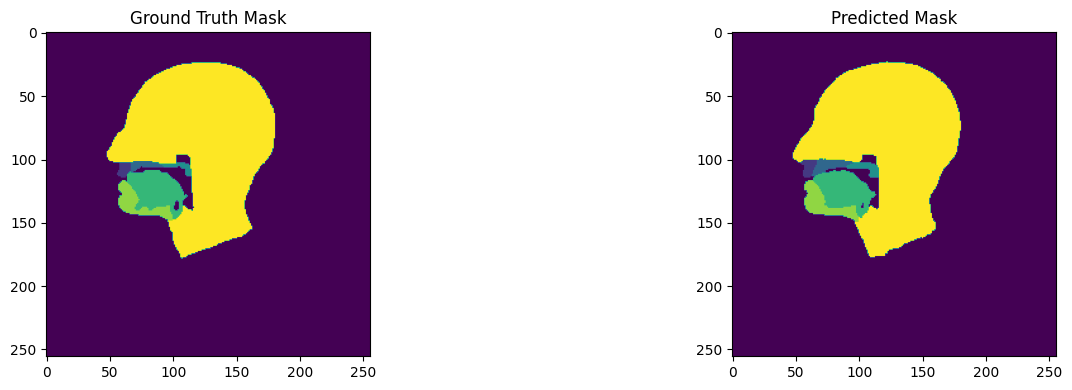

110/110 [==============================] - 118s 1s/step - loss: 0.0417 - accuracy: 0.9849 - precision: 0.9851 - recall: 0.9848 - Mean_DICE: 0.8587 - val_loss: 0.1144 - val_accuracy: 0.9880 - val_precision: 0.9881 - val_recall: 0.9880 - val_Mean_DICE: 0.8863 - lr: 1.5625e-05
Epoch 38/50
110/110 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9848 - precision: 0.9850 - recall: 0.9847 - Mean_DICE: 0.8862(256, 256, 1)


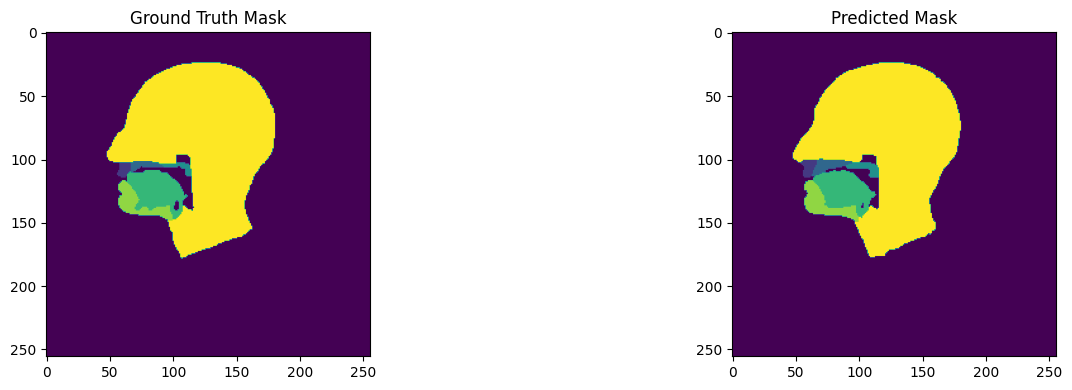

110/110 [==============================] - 118s 1s/step - loss: 0.0420 - accuracy: 0.9848 - precision: 0.9850 - recall: 0.9847 - Mean_DICE: 0.8862 - val_loss: 0.1153 - val_accuracy: 0.9880 - val_precision: 0.9881 - val_recall: 0.9879 - val_Mean_DICE: 0.8866 - lr: 1.5625e-05
Epoch 39/50
110/110 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9849 - precision: 0.9850 - recall: 0.9847 - Mean_DICE: 0.8614(256, 256, 1)


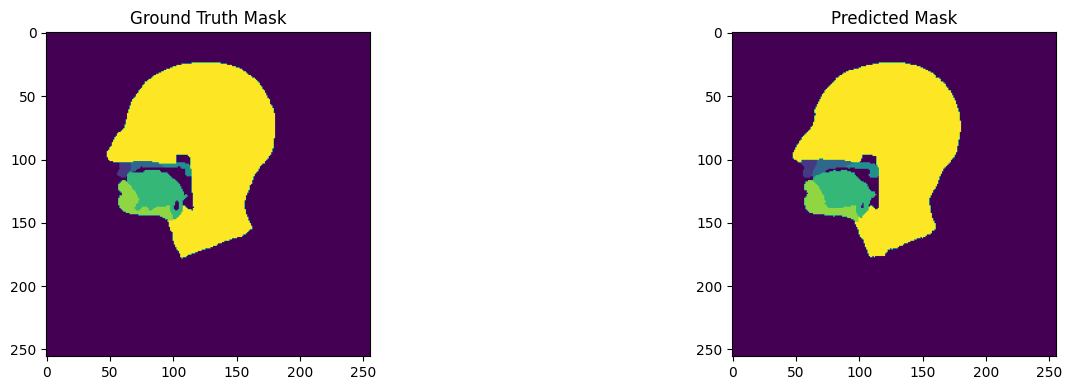

110/110 [==============================] - 123s 1s/step - loss: 0.0416 - accuracy: 0.9849 - precision: 0.9850 - recall: 0.9847 - Mean_DICE: 0.8614 - val_loss: 0.1165 - val_accuracy: 0.9879 - val_precision: 0.9880 - val_recall: 0.9879 - val_Mean_DICE: 0.8874 - lr: 1.0000e-05


In [ ]:
#model.fit --> actual training of the model using back-propagation for updating weights

model_history = model.fit(
    x = X_train_denoised,
    y = y_train,
    batch_size = 8,
    epochs = 50,
    validation_data =(X_val_denoised, y_val),
    callbacks = [early_stopping, scheduler, viz_callback]
).history


# Plot trend

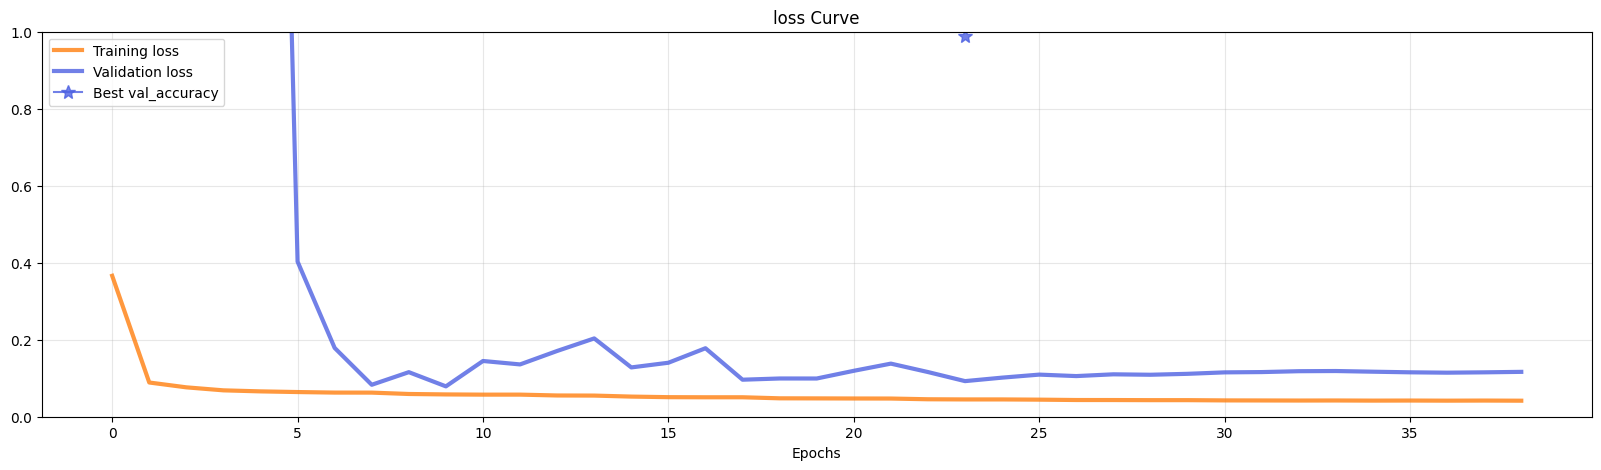

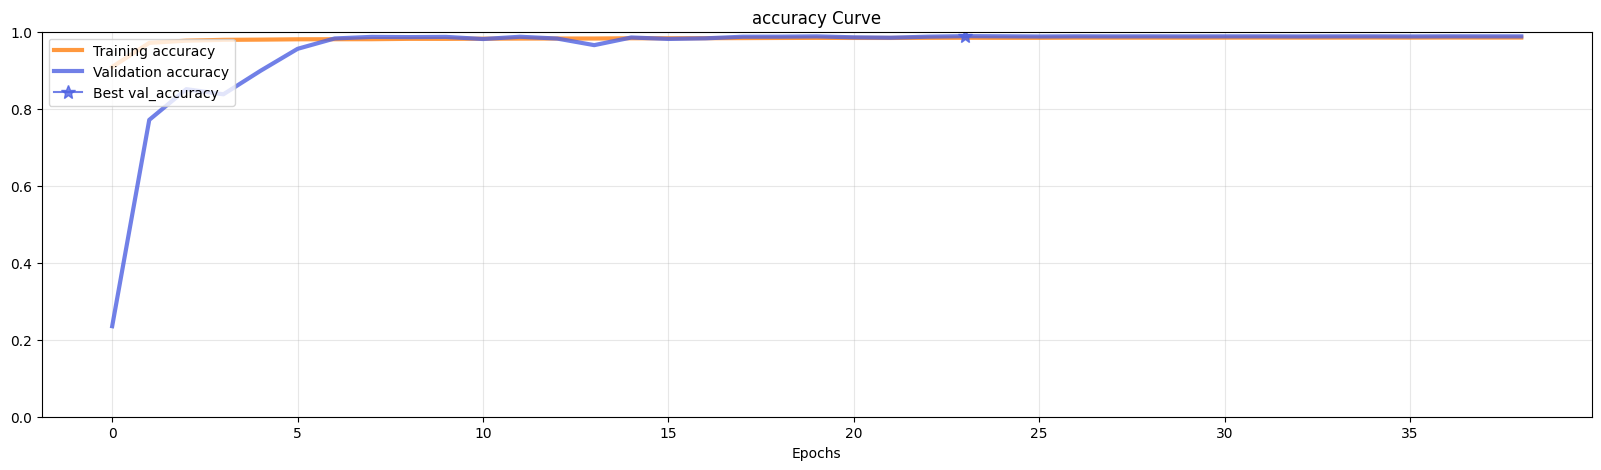

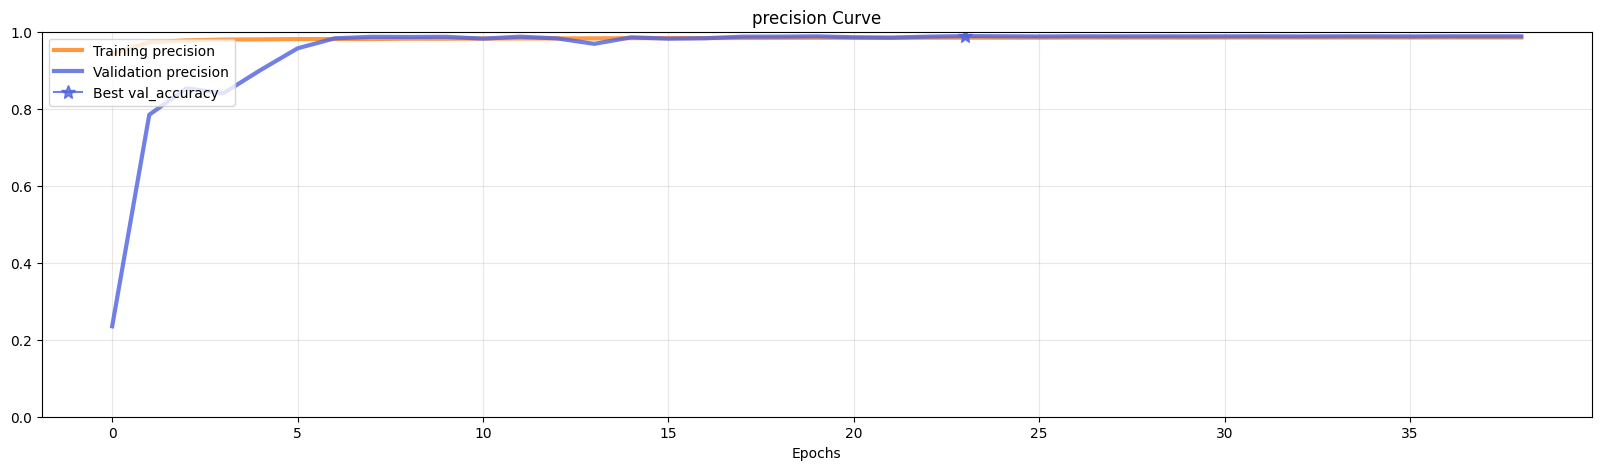

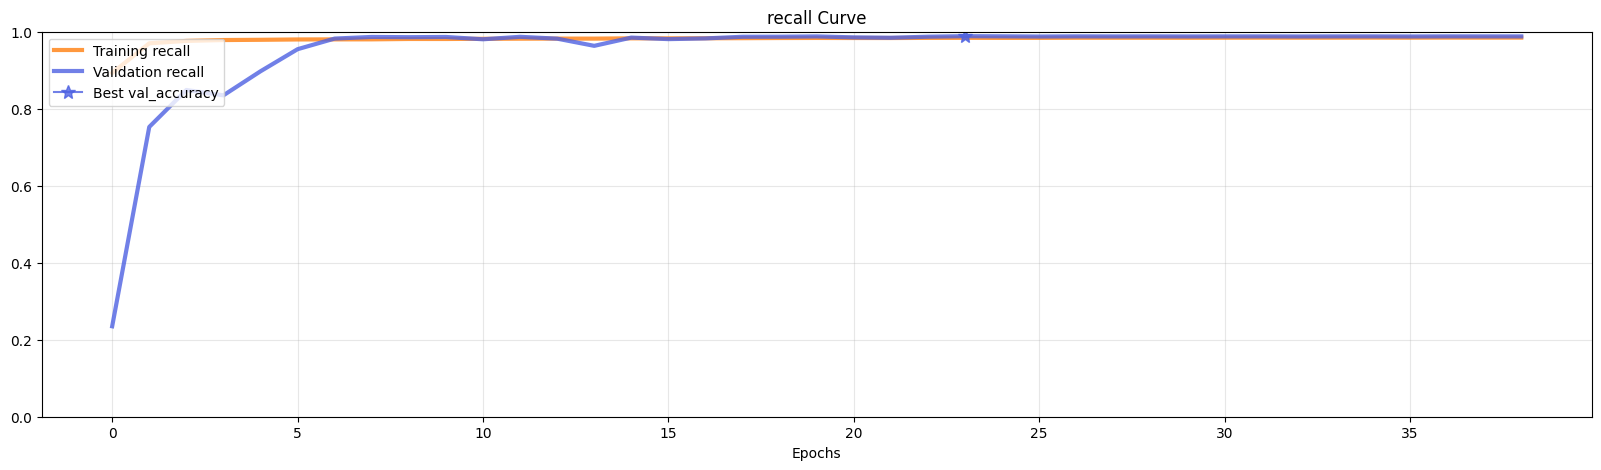

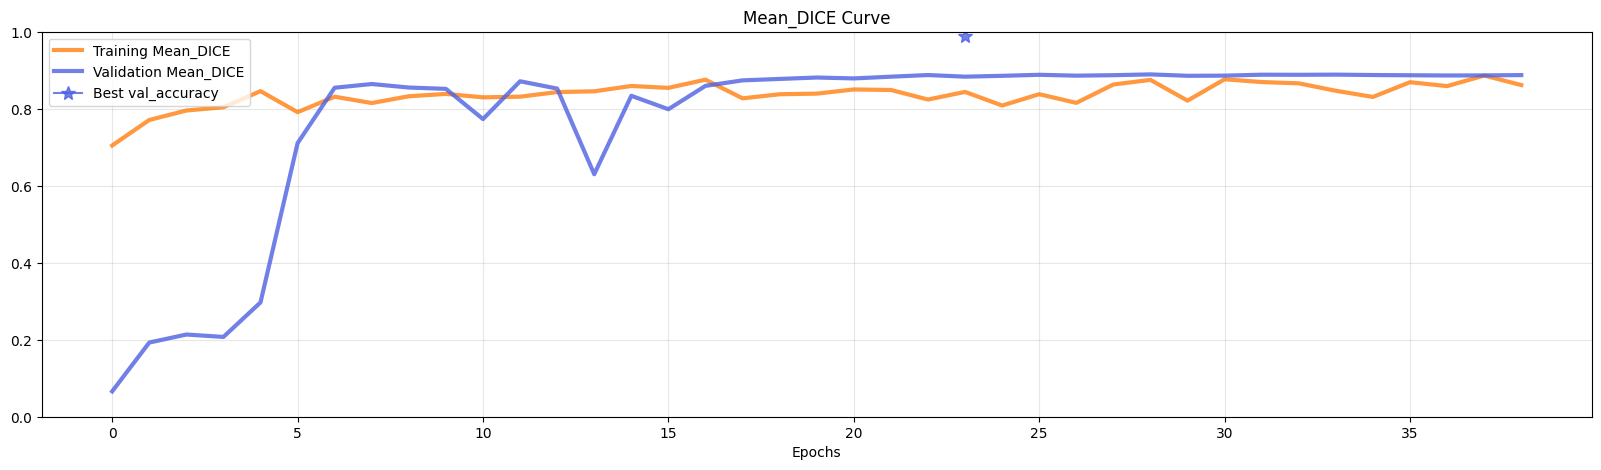

"\n    #salvo curve\n    output_dir=os.path.join(predictions_path,'figures')\n    os.mkdir(output_dir)\n    output_path = os.path.join(output_dir, f'{metrica}_curve.png')\n    plt.savefig(output_path)\n"

In [ ]:
metrica_max = 'val_Mean_DICE'
best_epoch = np.argmax(model_history[metrica_max])  # epoch with the highest validation accuracy

for (metrica, metrica_val) in [('loss', 'val_loss'), ('accuracy', 'val_accuracy'), ('precision', 'val_precision'), ('recall', 'val_recall'), ('Mean_DICE', 'val_Mean_DICE')]:
    plt.figure(figsize=(20, 5))
    plt.plot(model_history[metrica], label=f'Training {metrica}', alpha=0.8, color='#ff7f0e', linewidth=3)
    plt.plot(model_history[metrica_val], label=f'Validation {metrica}', alpha=0.8, color='#4D61E2', linewidth=3)
    plt.plot(best_epoch, model_history[metrica_max][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2', label=f'Best {metrica_max}')
    plt.legend(loc='upper left')
    plt.title(f'{metrica} Curve')
    plt.xlabel('Epochs')
    plt.grid(alpha=0.3)
    plt.ylim([0,1])
    plt.show()
'''
    #salvo curve
    output_dir=os.path.join(predictions_path,'figures')
    os.mkdir(output_dir)
    output_path = os.path.join(output_dir, f'{metrica}_curve.png')
    plt.savefig(output_path)
'''

In [ ]:
import pickle
file_path = '/content/gdrive/MyDrive/PROJECT_NEURO/AAA_SCRIPT_DEFINITIVI/model_history.pkl'

# Save the dictionary to a pickle file
with open(file_path, 'wb') as pickle_file:
    pickle.dump(model_history, pickle_file)

print(f"Dictionary saved to {file_path}")

Dictionary saved to /content/gdrive/MyDrive/PROJECT_NEURO/AAA_SCRIPT_DEFINITIVI/model_history.pkl


# Save best model

In [ ]:
model.save('gdrive/MyDrive/PROJECT_NEURO/AAA_SCRIPT_DEFINITIVI/MODELLO_DEFINITIVO')

# Predict

In [ ]:
del model
model = tf.keras.models.load_model('gdrive/MyDrive/PROJECT_NEURO/AAA_SCRIPT_DEFINITIVI/MODELLO_DEFINITIVO', custom_objects={'Mean_DICE': Mean_DICE, 'loss': weighted_cross_entropy})

In [ ]:
y_pred=model.predict(X_test_denoised)

3/3 [==============================] - 28s 6s/step


# Post-process
we apply argmax as postprocessing. We decided to not include other filters (es. median) because the model is quite good both in constant areas (es. background) and in small regions (es. upper lip).
Post-processing is performed directly in 'performance' function, then this function is applied to validation and test sets

##Performance function

In [ ]:
def performance(X_denoised,y_val,model,PRINT=True,RETURN=False):

  classes=['Background and vocal tract','Upper lip','Hard palate','Soft palate','Tongue','Lower lip','Head']
  #POSTPROCESSING
  y_pred=model.predict(X_denoised) #(N,256,256,7) prediction of the model expressed as probabilities
  y_pred_array=np.argmax(y_pred,axis=-1) #(N,256,256) prediction of the model expressed as class index
  y_pred_one_hot=np.stack([(y_pred_array == level).astype(int) for level in np.linspace(0, 6, 7)], axis=-1) #(N,256,256,7) predicted binary masks for each class
  y_pred_flat = y_pred_one_hot.reshape(-1, 7) #(Nx256x256,7) predicted binary array for each class
  y_pred_argmax = np.argmax(y_pred_flat, axis=1) #(Nx256x256) one vector with position of the max for each pixel but flatten

  y_val_flat = y_val.reshape(-1, 7) #(Nx256x256,7) ground truth expressed as vector for each class
  y_val_argmax = np.argmax(y_val_flat, axis=1) #(Nx256x256) one vector with the position of the the max numbers as ground truth


  #Mean_DICE without argmax
  mean_dice_metric = Mean_DICE(NUM_CLASSES)
  mean_dice_metric.update_state(y_pred, y_val)
  mean_dice_without_argmax=mean_dice_metric.result().numpy()

  #Mean_DICE with argmax
  mean_dice_metric = Mean_DICE(NUM_CLASSES)
  mean_dice_metric.update_state(y_pred_one_hot, y_val)
  mean_dice_with_argmax=mean_dice_metric.result().numpy()

  #Mean_IoU without argmax
  mean_IoU=tfk.metrics.MeanIoU(num_classes=NUM_CLASSES)
  mean_IoU.update_state(y_pred, y_val)
  mean_IoU_without_argmax=mean_IoU.result().numpy()

  #Mean_IoU with argmax
  mean_IoU.update_state(y_pred_one_hot, y_val)
  mean_IoU_with_argmax=mean_IoU.result().numpy()

  #Accuracy
  accuracy = accuracy_score(y_val_argmax, y_pred_argmax)

  #Precision
  precision_per_class=precision_score(y_val_argmax, y_pred_argmax, average=None)
  precision_macro=precision_score(y_val_argmax, y_pred_argmax, average='macro') #con average=None restituisce la lista con precision per ogni classe
  precision_weighted=precision_score(y_val_argmax, y_pred_argmax, average='weighted')

  #Recall
  recall_per_class=recall_score(y_val_argmax, y_pred_argmax, average=None)
  recall_macro=recall_score(y_val_argmax, y_pred_argmax, average='macro')
  recall_weighted=recall_score(y_val_argmax, y_pred_argmax, average='weighted')

  # Confusion matrix
  conf_matrix = confusion_matrix(y_val_argmax,y_pred_argmax)
  conf_matrix_norm=conf_matrix/sum(conf_matrix) #normalize to obtain frequencies

  if PRINT:
    print('mean_dice_metric_without_argmax: ', mean_dice_without_argmax)
    print('mean_dice_metric_with_argmax: ', mean_dice_with_argmax)
    print('mean_IoU_without_argmax: ',mean_IoU_without_argmax)
    print('mean_IoU_with_argmax: ',mean_IoU_with_argmax)
    print('accuracy: ',accuracy)
    print('precision_macro: ',precision_macro)
    print('precision_weighted: ',precision_weighted)
    print('recall_macro: ',recall_macro)
    print('recall_weighted: ',recall_weighted)

    for i in range(7):
      print('\nClass: ',classes[i],' (',i,'):')
      print('Precision: ',precision_per_class[i])
      print('Recall: ',recall_per_class[i])

    plt.figure(figsize=(10,10))
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    if RETURN:
      return (mean_dice_without_argmax,mean_dice_with_argmax,mean_IoU_without_argmax,mean_IoU_with_argmax,accuracy,precision_per_class,precision_macro,precision_weighted,recall_per_class,recall_macro,recall_weighted,conf_matrix_norm)
    else:
      return

## Performance on validation

6/6 [==============================] - 4s 813ms/step
mean_dice_metric_without_argmax:  0.88599735
mean_dice_metric_with_argmax:  0.8910985
mean_IoU_without_argmax:  0.79194844
mean_IoU_with_argmax:  0.8842663
accuracy:  0.9879546370243002
precision_macro:  0.8381979009894713
precision_weighted:  0.9887357062348928
recall_macro:  0.9672077247402663
recall_weighted:  0.9879546370243002

Class:  Background and vocal tract  ( 0 ):
Precision:  0.992984247453816
Recall:  0.9942173588986608

Class:  Upper lip  ( 1 ):
Precision:  0.7356233114627557
Recall:  0.9747144724132053

Class:  Hard palate  ( 2 ):
Precision:  0.6937551211518203
Recall:  0.9535435604537045

Class:  Soft palate  ( 3 ):
Precision:  0.6277692216562019
Recall:  0.9464753512741129

Class:  Tongue  ( 4 ):
Precision:  0.919608783827987
Recall:  0.971122292714942

Class:  Lower lip  ( 5 ):
Precision:  0.9085856650057493
Recall:  0.9667502309011743

Class:  Head  ( 6 ):
Precision:  0.9890589563679689
Recall:  0.9636308065260648


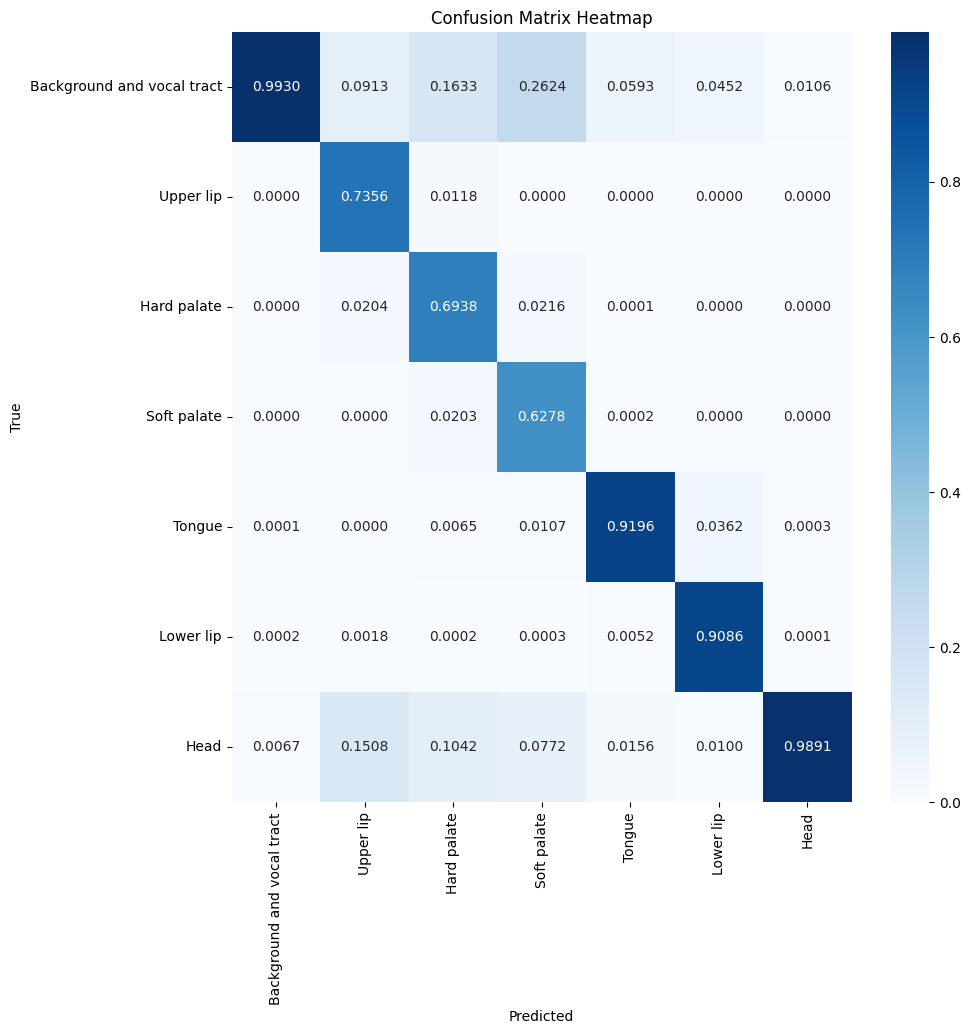

In [ ]:
performance(X_val_denoised,y_val,model)